# Importing Libraries, data, and setup

In [1]:
import random
import math
import os
import time
import numpy as np
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 44069563.79it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 86773419.64it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28499513.31it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3884691.84it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# The RNN Class

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, layers = 1, rnn_cell_type = 'vanilla', bidirectional = False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = layers
        self.bidirectional = bidirectional

        if rnn_cell_type == 'vanilla':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers = layers, batch_first = True, bidirectional = bidirectional)
        elif rnn_cell_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers = layers, batch_first = True, bidirectional = bidirectional)
        elif rnn_cell_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers = layers, batch_first = True, bidirectional = bidirectional)

        linear_input_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(linear_input_size, output_size)

    def forward(self, x):
        x = x.view(-1, 28, 28)
        num_dirs = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.num_layers*num_dirs, x.size(0), self.hidden_size).to(device)
        if isinstance(self.rnn, nn.LSTM):
            c0 = torch.zeros(self.num_layers*num_dirs, x.size(0), self.hidden_size).to(device)
            out, _ = self.rnn(x, (h0, c0))
        else:
            out, _ = self.rnn(x, h0)

        if self.bidirectional:
            out = torch.cat((out[:, -1, :self.hidden_size], out[:, 0, self.hidden_size:]), 1)
        else:
            out = out[:, -1, :]

        return self.fc(out)

# Some useful functions

## Function to train and test the model

In [ ]:
def train_and_evaluate(input_dim, hidden_dim, output_dim, train_loader, val_loader, test_loader, layers, rnn_cell_type, bidirectional):
    net = RNN(input_dim, hidden_dim, output_dim, layers, rnn_cell_type, bidirectional).to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(net.parameters())

    num_epochs = 5
    train_losses, val_losses, accuracies = [], [], []

    start_time = time.time()
    for epoch in range(num_epochs):
        # Training
        net.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        net.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                val_loss += criterion(outputs, labels).item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = 100. * correct / total

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%')

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        accuracies.append(epoch_val_accuracy)
    end_time = time.time()

    elapsed_time = end_time - start_time
    print(f"Training using {rnn_cell_type.upper()} took {elapsed_time:.2f} seconds.")

    # Plotting
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title(f'{rnn_cell_type.upper()} - Train and Validation Losses')

    plt.subplot(1, 3, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title(f'{rnn_cell_type.upper()} - Validation Accuracy')

    plt.tight_layout()
    plt.show()

    test_preds, test_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1)
            test_true.extend(labels.cpu().numpy())
            test_preds.extend(predicted.cpu().numpy())

    acc = 100. * sum(np.array(test_true) == np.array(test_preds)) / len(test_true)

    return epoch_val_accuracy, acc, classification_report(test_true, test_preds), confusion_matrix(test_true, test_preds), net

## Function to plot results

In [ ]:
def display_results(rnn_cell_type, results):
    print(f"\nResults for {rnn_cell_type.upper()} RNN:")
    print(f"Accuracy: {results[1]:.2f}%")
    print(f"\nClassification Report:\n{results[2]}")

    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(results[3], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {rnn_cell_type.upper()} RNN")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Function to plot predictions

In [ ]:
def plot_predictions(model, loader, num_samples=12):
    all_images, all_labels = [], []
    for images, labels in loader:
        all_images.append(images)
        all_labels.append(labels)
    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)

    random_indices = random.sample(range(len(all_images)), num_samples)
    images = all_images[random_indices]
    labels = all_labels[random_indices]

    outputs = model(images.to(device))
    _, predictions = outputs.max(1)

    grid_size = int(math.ceil(math.sqrt(num_samples)))

    plt.figure(figsize=(15, 15))
    for i, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(img[0].numpy(), cmap='gray')
        plt.title(f"True: {label.item()}, Pred: {pred.item()}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tuning the hyperparameters with vanilla RNN using a grid-search approach

In [ ]:
hidden_layer_list = [64, 128]
num_layers_list = [1, 2, 3, 4, 5]

best_val_acc = 0.0
best_model = None
best_hidden_size = None
best_num_layers = None

Training with hidden size: 64, num layers: 1
Epoch: 1/5, Train Loss: 1.2213, Validation Loss: 1.0592, Validation Accuracy: 62.17%
Epoch: 2/5, Train Loss: 0.8230, Validation Loss: 0.7057, Validation Accuracy: 75.79%
Epoch: 3/5, Train Loss: 0.6698, Validation Loss: 0.6312, Validation Accuracy: 78.70%
Epoch: 4/5, Train Loss: 0.5682, Validation Loss: 0.5271, Validation Accuracy: 83.58%
Epoch: 5/5, Train Loss: 0.4481, Validation Loss: 0.4112, Validation Accuracy: 87.99%
Training using VANILLA took 47.14 seconds.


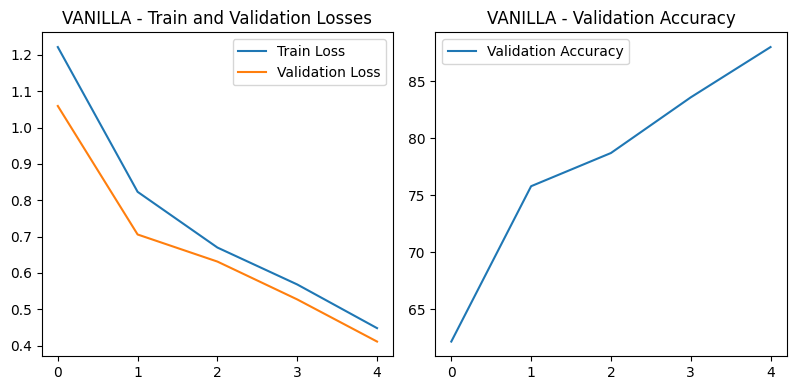

New best model found with validation accuracy: 87.99%
Training with hidden size: 64, num layers: 2
Epoch: 1/5, Train Loss: 0.8001, Validation Loss: 0.4300, Validation Accuracy: 87.24%
Epoch: 2/5, Train Loss: 0.3441, Validation Loss: 0.3216, Validation Accuracy: 90.87%
Epoch: 3/5, Train Loss: 0.2445, Validation Loss: 0.2514, Validation Accuracy: 93.04%
Epoch: 4/5, Train Loss: 0.2022, Validation Loss: 0.1701, Validation Accuracy: 95.29%
Epoch: 5/5, Train Loss: 0.1723, Validation Loss: 0.1780, Validation Accuracy: 95.18%
Training using VANILLA took 45.35 seconds.


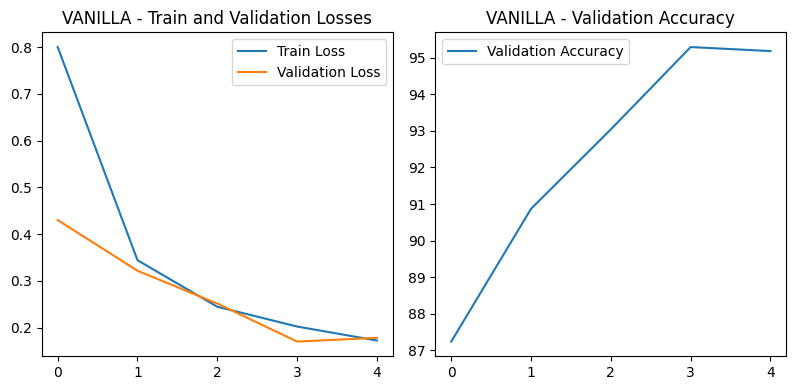

New best model found with validation accuracy: 95.18%
Training with hidden size: 64, num layers: 3
Epoch: 1/5, Train Loss: 0.7711, Validation Loss: 0.3705, Validation Accuracy: 89.24%
Epoch: 2/5, Train Loss: 0.3116, Validation Loss: 0.2503, Validation Accuracy: 92.73%
Epoch: 3/5, Train Loss: 0.2321, Validation Loss: 0.2221, Validation Accuracy: 93.33%
Epoch: 4/5, Train Loss: 0.2139, Validation Loss: 0.2213, Validation Accuracy: 93.34%
Epoch: 5/5, Train Loss: 0.1824, Validation Loss: 0.2027, Validation Accuracy: 93.94%
Training using VANILLA took 47.76 seconds.


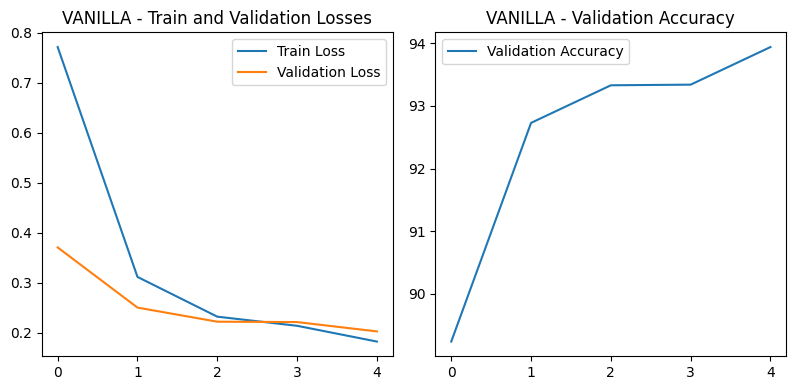

Training with hidden size: 64, num layers: 4
Epoch: 1/5, Train Loss: 0.7350, Validation Loss: 0.3502, Validation Accuracy: 89.80%
Epoch: 2/5, Train Loss: 0.2950, Validation Loss: 0.2220, Validation Accuracy: 93.54%
Epoch: 3/5, Train Loss: 0.2103, Validation Loss: 0.1915, Validation Accuracy: 94.50%
Epoch: 4/5, Train Loss: 0.1775, Validation Loss: 0.1781, Validation Accuracy: 94.86%
Epoch: 5/5, Train Loss: 0.1447, Validation Loss: 0.1604, Validation Accuracy: 95.45%
Training using VANILLA took 58.77 seconds.


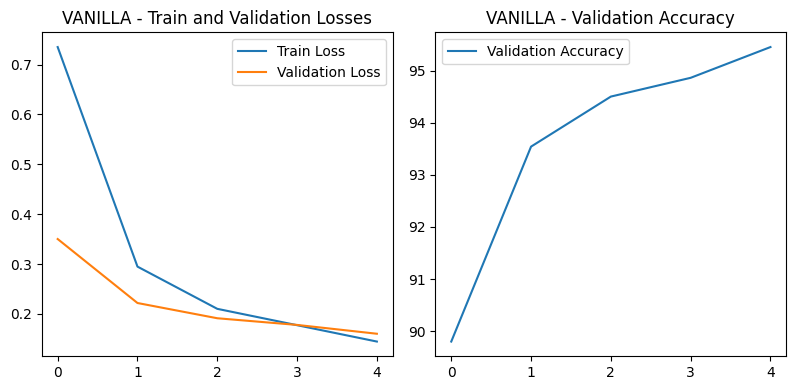

New best model found with validation accuracy: 95.45%
Training with hidden size: 64, num layers: 5
Epoch: 1/5, Train Loss: 0.6420, Validation Loss: 0.3978, Validation Accuracy: 87.94%
Epoch: 2/5, Train Loss: 0.2429, Validation Loss: 0.2188, Validation Accuracy: 93.84%
Epoch: 3/5, Train Loss: 0.1755, Validation Loss: 0.1517, Validation Accuracy: 95.82%
Epoch: 4/5, Train Loss: 0.1503, Validation Loss: 0.1577, Validation Accuracy: 95.57%
Epoch: 5/5, Train Loss: 0.1328, Validation Loss: 0.1286, Validation Accuracy: 96.36%
Training using VANILLA took 49.15 seconds.


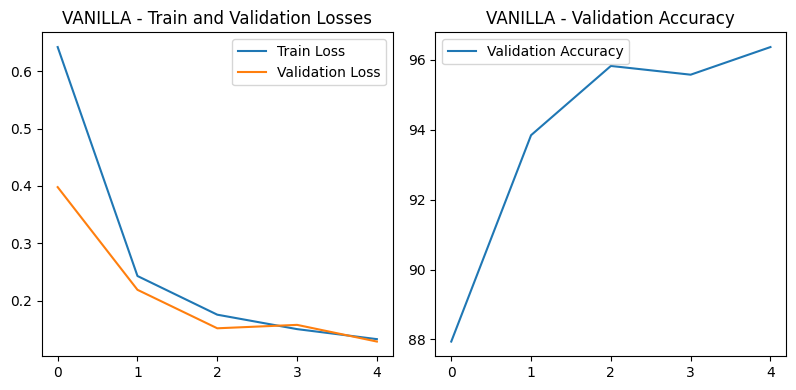

New best model found with validation accuracy: 96.36%
Training with hidden size: 128, num layers: 1
Epoch: 1/5, Train Loss: 0.9751, Validation Loss: 0.7643, Validation Accuracy: 76.06%
Epoch: 2/5, Train Loss: 0.4922, Validation Loss: 0.3600, Validation Accuracy: 89.75%
Epoch: 3/5, Train Loss: 0.2995, Validation Loss: 0.2609, Validation Accuracy: 92.60%
Epoch: 4/5, Train Loss: 0.2381, Validation Loss: 0.2129, Validation Accuracy: 94.01%
Epoch: 5/5, Train Loss: 0.1970, Validation Loss: 0.2309, Validation Accuracy: 93.87%
Training using VANILLA took 48.32 seconds.


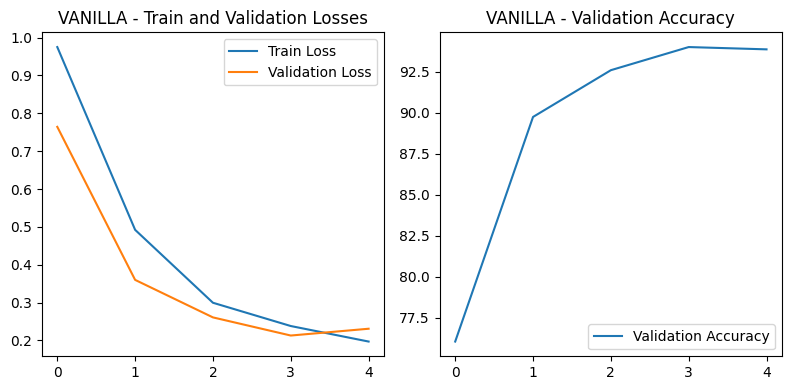

Training with hidden size: 128, num layers: 2
Epoch: 1/5, Train Loss: 0.6611, Validation Loss: 0.3406, Validation Accuracy: 89.23%
Epoch: 2/5, Train Loss: 0.2923, Validation Loss: 0.2333, Validation Accuracy: 93.48%
Epoch: 3/5, Train Loss: 0.2205, Validation Loss: 0.1966, Validation Accuracy: 94.36%
Epoch: 4/5, Train Loss: 0.1807, Validation Loss: 0.1801, Validation Accuracy: 95.01%
Epoch: 5/5, Train Loss: 0.1494, Validation Loss: 0.2026, Validation Accuracy: 94.15%
Training using VANILLA took 45.65 seconds.


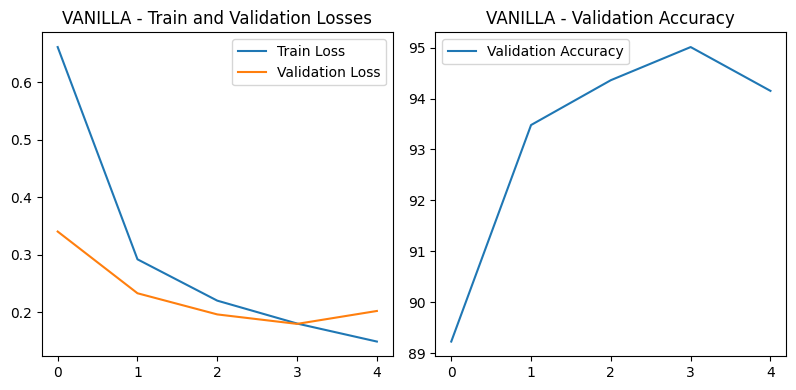

Training with hidden size: 128, num layers: 3
Epoch: 1/5, Train Loss: 0.5694, Validation Loss: 0.3802, Validation Accuracy: 88.76%
Epoch: 2/5, Train Loss: 0.2527, Validation Loss: 0.1961, Validation Accuracy: 94.25%
Epoch: 3/5, Train Loss: 0.1893, Validation Loss: 0.1570, Validation Accuracy: 95.59%
Epoch: 4/5, Train Loss: 0.1704, Validation Loss: 0.1988, Validation Accuracy: 94.22%
Epoch: 5/5, Train Loss: 0.1533, Validation Loss: 0.2105, Validation Accuracy: 93.94%
Training using VANILLA took 46.91 seconds.


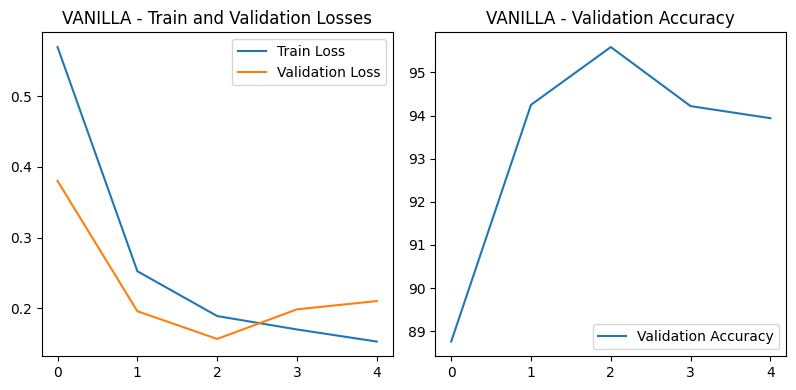

Training with hidden size: 128, num layers: 4
Epoch: 1/5, Train Loss: 0.7114, Validation Loss: 0.4073, Validation Accuracy: 87.53%
Epoch: 2/5, Train Loss: 0.3211, Validation Loss: 0.2877, Validation Accuracy: 91.73%
Epoch: 3/5, Train Loss: 0.2357, Validation Loss: 0.2123, Validation Accuracy: 94.18%
Epoch: 4/5, Train Loss: 0.1954, Validation Loss: 0.2232, Validation Accuracy: 93.71%
Epoch: 5/5, Train Loss: 0.1857, Validation Loss: 0.1596, Validation Accuracy: 95.33%
Training using VANILLA took 47.98 seconds.


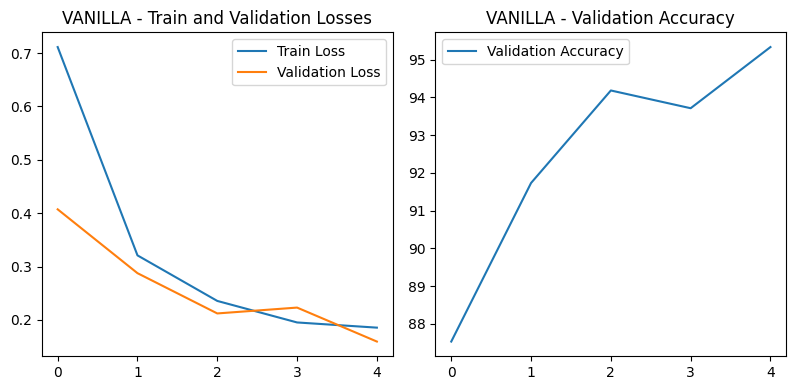

Training with hidden size: 128, num layers: 5
Epoch: 1/5, Train Loss: 0.6193, Validation Loss: 0.3309, Validation Accuracy: 90.40%
Epoch: 2/5, Train Loss: 0.3002, Validation Loss: 0.2787, Validation Accuracy: 91.73%
Epoch: 3/5, Train Loss: 0.2412, Validation Loss: 0.2322, Validation Accuracy: 93.47%
Epoch: 4/5, Train Loss: 0.2038, Validation Loss: 0.1748, Validation Accuracy: 94.84%
Epoch: 5/5, Train Loss: 0.1687, Validation Loss: 0.2604, Validation Accuracy: 91.95%
Training using VANILLA took 50.55 seconds.


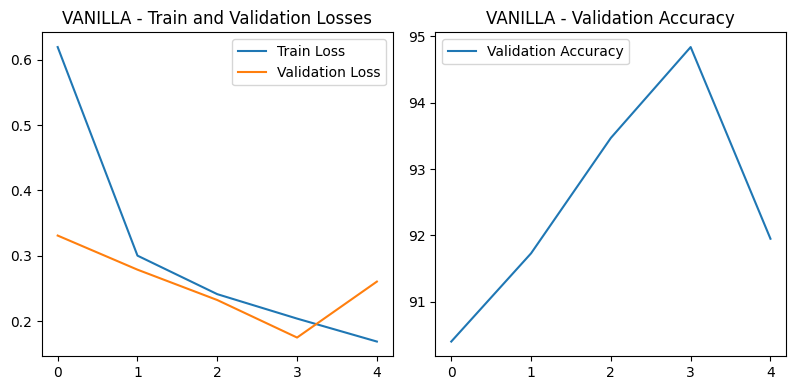

In [ ]:
for hidden_size in hidden_layer_list:
    for num_layers in num_layers_list:
        print(f'Training with hidden size: {hidden_size}, num layers: {num_layers}')
        val_acc, acc, _, _, net = train_and_evaluate(
            input_dim=28,
            hidden_dim=hidden_size,
            output_dim=10,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            layers=num_layers,
            rnn_cell_type='vanilla',
            bidirectional=False
        )

        if val_acc > best_val_acc:  # check the validation accuracy to update the best model
            best_val_acc = val_acc
            best_model = net
            best_hidden_size = hidden_size
            best_num_layers = num_layers
            print(f'New best model found with validation accuracy: {best_val_acc:.2f}%')

In [ ]:
save_path = f'/content/drive/MyDrive/EE5179 DLI/Assignment3/best_model/best_model_hidden_{best_hidden_size}_layers_{best_num_layers}.pt'
torch.save(best_model.state_dict(), save_path)
print(f'Best model saved to {save_path} with accuracy: {best_val_acc:.2f}%')

Best model saved to /content/drive/MyDrive/EE5179 DLI/Assignment3/best_model/best_model_hidden_64_layers_5.pt with accuracy: 96.36%


We get the best performance with hidden state size of 64 and 5 layers. We'll stick with this conifiguration for all the further experiments.

# Performance with uni-directional models

In [ ]:
in_dim = 28
hidden_dim = 64
out_dim = 10
num_layers = 5
bidir = False

Epoch: 1/5, Train Loss: 0.7325, Validation Loss: 0.4398, Validation Accuracy: 87.32%
Epoch: 2/5, Train Loss: 0.2664, Validation Loss: 0.2095, Validation Accuracy: 94.29%
Epoch: 3/5, Train Loss: 0.1895, Validation Loss: 0.3207, Validation Accuracy: 90.25%
Epoch: 4/5, Train Loss: 0.1742, Validation Loss: 0.1558, Validation Accuracy: 95.48%
Epoch: 5/5, Train Loss: 0.1457, Validation Loss: 0.1846, Validation Accuracy: 94.97%
Training using VANILLA took 57.67 seconds.


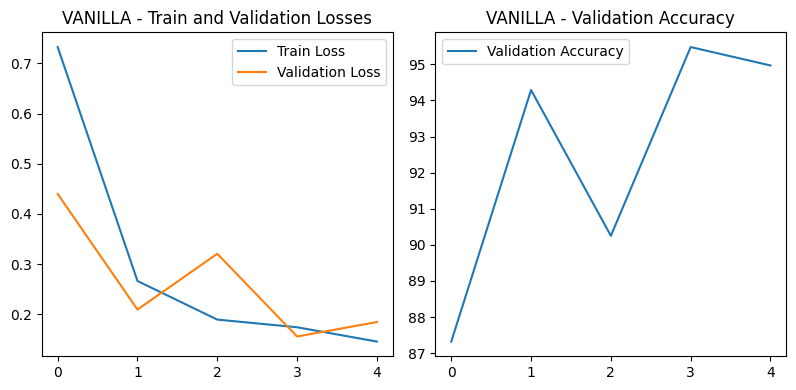

In [ ]:
rnn_type = 'vanilla'
rnn_res =  train_and_evaluate(in_dim, hidden_dim, out_dim, train_loader, val_loader, test_loader, num_layers, rnn_type, bidir)


Results for VANILLA RNN:
Accuracy: 95.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.93      0.97      0.95      1032
           3       0.94      0.97      0.96      1010
           4       0.98      0.87      0.92       982
           5       0.95      0.96      0.95       892
           6       0.95      0.96      0.96       958
           7       0.94      0.96      0.95      1028
           8       0.98      0.90      0.94       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



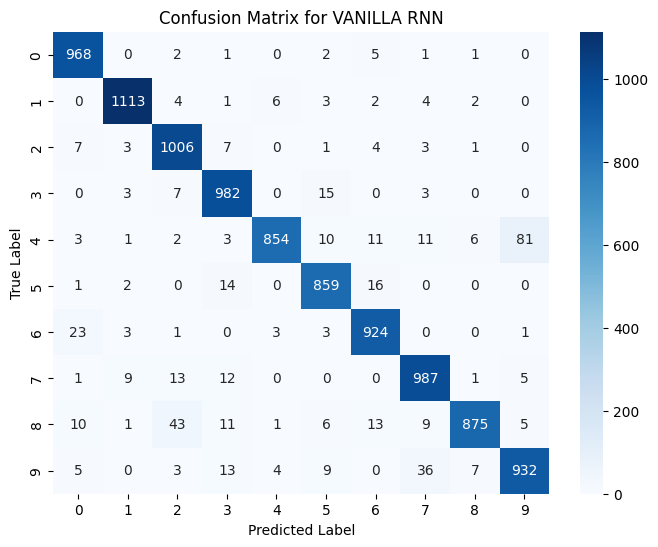

In [ ]:
display_results(rnn_type, rnn_res)

Epoch: 1/5, Train Loss: 0.5521, Validation Loss: 0.2212, Validation Accuracy: 93.35%
Epoch: 2/5, Train Loss: 0.1335, Validation Loss: 0.1032, Validation Accuracy: 96.99%
Epoch: 3/5, Train Loss: 0.0884, Validation Loss: 0.0863, Validation Accuracy: 97.56%
Epoch: 4/5, Train Loss: 0.0654, Validation Loss: 0.0689, Validation Accuracy: 98.01%
Epoch: 5/5, Train Loss: 0.0545, Validation Loss: 0.0639, Validation Accuracy: 98.24%
Training using GRU took 49.94 seconds.


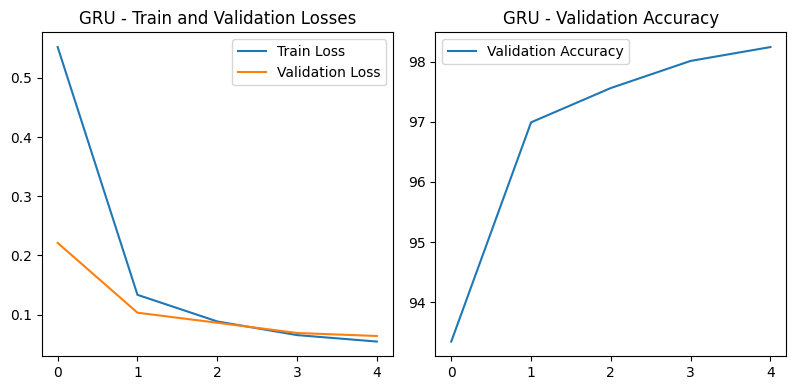

In [ ]:
rnn_type = 'gru'
gru_res = train_and_evaluate(in_dim, hidden_dim, out_dim, train_loader, val_loader, test_loader, num_layers, rnn_type, bidir)


Results for GRU RNN:
Accuracy: 98.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.97      0.99      0.98      1032
           3       0.99      0.97      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.98      0.99      0.98       892
           6       0.98      0.98      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



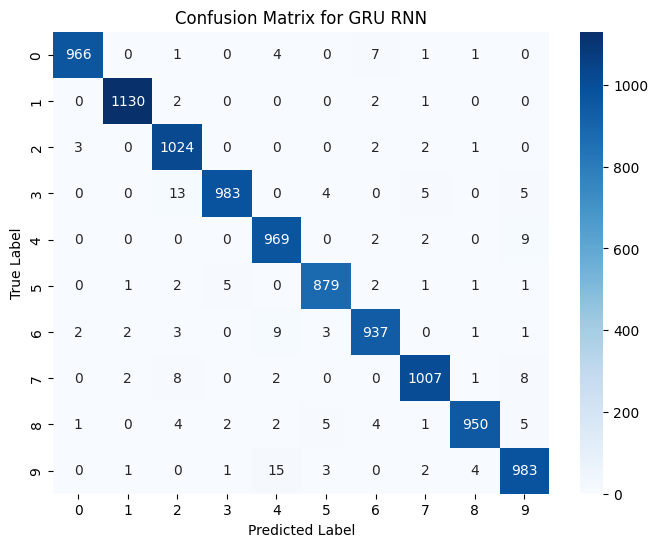

In [ ]:
display_results(rnn_type, gru_res)

Epoch: 1/5, Train Loss: 0.7443, Validation Loss: 0.2628, Validation Accuracy: 92.42%
Epoch: 2/5, Train Loss: 0.1930, Validation Loss: 0.1552, Validation Accuracy: 95.56%
Epoch: 3/5, Train Loss: 0.1235, Validation Loss: 0.1200, Validation Accuracy: 96.50%
Epoch: 4/5, Train Loss: 0.0949, Validation Loss: 0.0957, Validation Accuracy: 96.98%
Epoch: 5/5, Train Loss: 0.0762, Validation Loss: 0.0792, Validation Accuracy: 97.75%
Training using LSTM took 51.67 seconds.


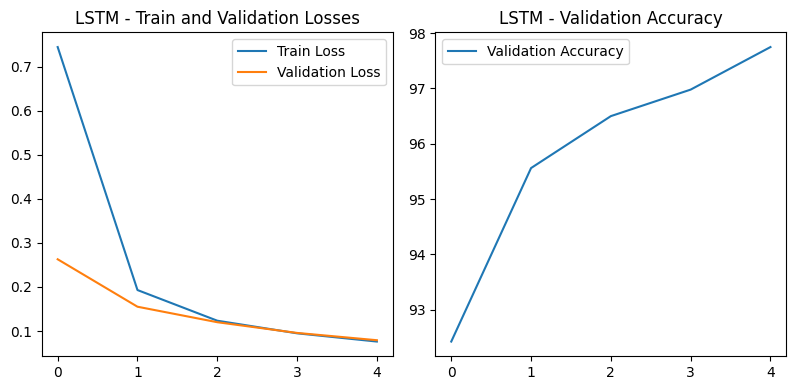

In [ ]:
rnn_type = 'lstm'
lstm_res = train_and_evaluate(in_dim, hidden_dim, out_dim, train_loader, val_loader, test_loader, num_layers, rnn_type, bidir)


Results for LSTM RNN:
Accuracy: 97.91%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.94      0.98      0.96      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



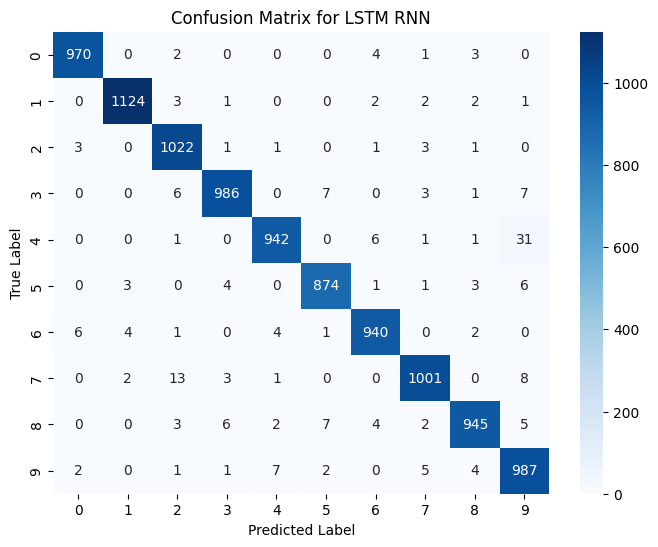

In [ ]:
display_results(rnn_type, lstm_res)

The GRU has the best performance and is the least time consuming.

# Perfromance with bi-directional models

Ideally one should also tune hyperparameters for a bi-directional setup separately because the number of layers double, but for this simple dataset, we'll just stick with the best hyperparams from the uni-directional tuning experiment.

In [ ]:
bidir = True

Epoch: 1/5, Train Loss: 0.4914, Validation Loss: 0.2568, Validation Accuracy: 92.11%
Epoch: 2/5, Train Loss: 0.1840, Validation Loss: 0.1572, Validation Accuracy: 95.24%
Epoch: 3/5, Train Loss: 0.1387, Validation Loss: 0.1394, Validation Accuracy: 95.83%
Epoch: 4/5, Train Loss: 0.1380, Validation Loss: 0.1317, Validation Accuracy: 96.19%
Epoch: 5/5, Train Loss: 0.1115, Validation Loss: 0.1337, Validation Accuracy: 96.23%
Training using VANILLA took 62.32 seconds.


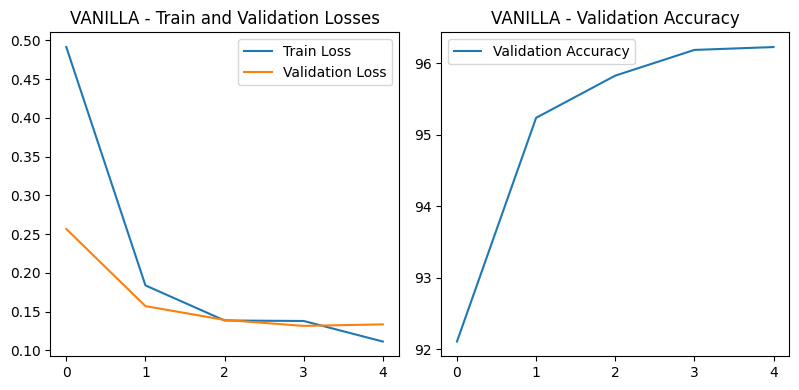

In [ ]:
rnn_type = 'vanilla'
bi_rnn_res = train_and_evaluate(in_dim, hidden_dim, out_dim, train_loader, val_loader, test_loader, num_layers, rnn_type, bidir)


Results for VANILLA RNN:
Accuracy: 96.75%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.93      0.99      0.96       892
           6       0.95      0.98      0.96       958
           7       0.95      0.98      0.97      1028
           8       0.99      0.92      0.95       974
           9       0.97      0.94      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



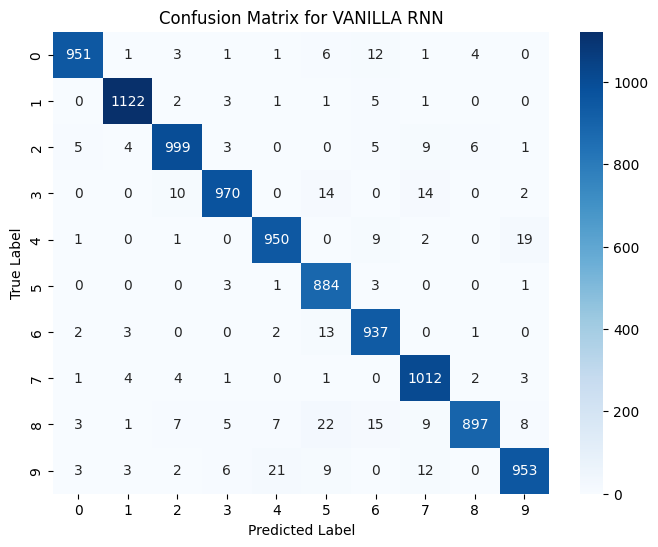

In [ ]:
display_results(rnn_type, bi_rnn_res)

Epoch: 1/5, Train Loss: 0.3484, Validation Loss: 0.1105, Validation Accuracy: 96.52%
Epoch: 2/5, Train Loss: 0.0852, Validation Loss: 0.0782, Validation Accuracy: 97.69%
Epoch: 3/5, Train Loss: 0.0584, Validation Loss: 0.0626, Validation Accuracy: 98.16%
Epoch: 4/5, Train Loss: 0.0448, Validation Loss: 0.0667, Validation Accuracy: 98.15%
Epoch: 5/5, Train Loss: 0.0363, Validation Loss: 0.0441, Validation Accuracy: 98.72%
Training using GRU took 62.74 seconds.


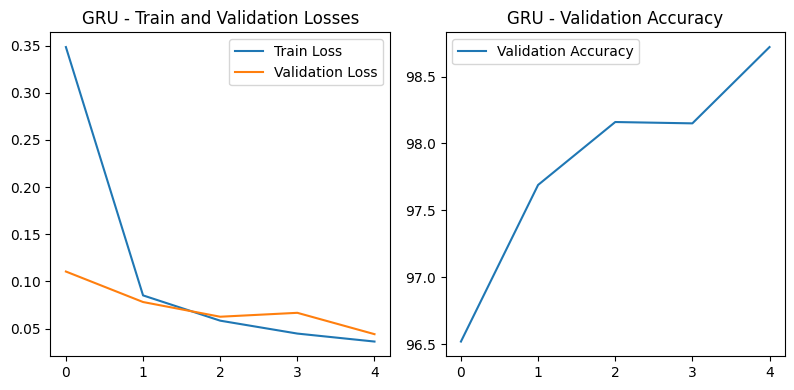

In [ ]:
rnn_type = 'gru'
bi_gru_res = train_and_evaluate(in_dim, hidden_dim, out_dim, train_loader, val_loader, test_loader, num_layers, rnn_type, bidir)


Results for GRU RNN:
Accuracy: 98.61%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



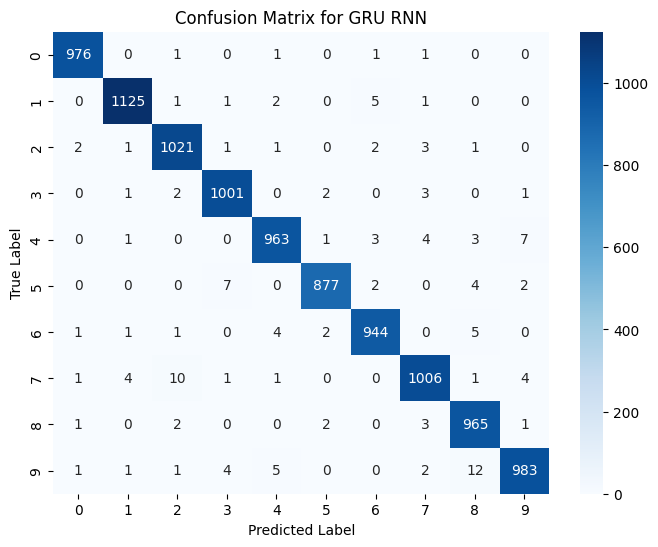

In [ ]:
display_results(rnn_type, bi_gru_res)

Epoch: 1/5, Train Loss: 0.5315, Validation Loss: 0.1800, Validation Accuracy: 94.70%
Epoch: 2/5, Train Loss: 0.1271, Validation Loss: 0.1241, Validation Accuracy: 96.36%
Epoch: 3/5, Train Loss: 0.0827, Validation Loss: 0.0888, Validation Accuracy: 97.30%
Epoch: 4/5, Train Loss: 0.0700, Validation Loss: 0.0806, Validation Accuracy: 97.77%
Epoch: 5/5, Train Loss: 0.0584, Validation Loss: 0.0670, Validation Accuracy: 97.92%
Training using LSTM took 61.25 seconds.


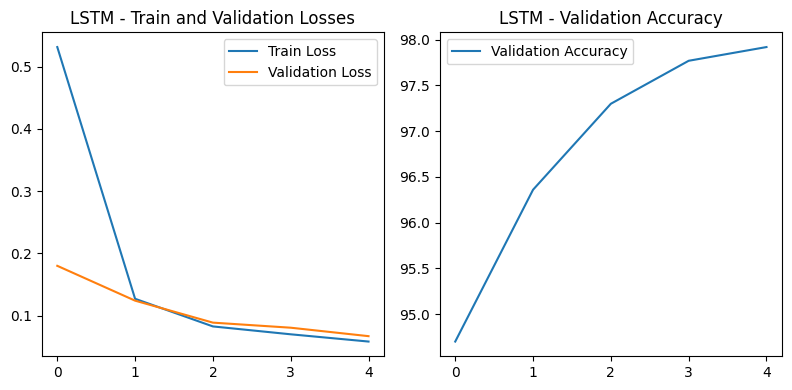

In [ ]:
rnn_type = 'lstm'
bi_lstm_res = train_and_evaluate(in_dim, hidden_dim, out_dim, train_loader, val_loader, test_loader, num_layers, rnn_type, bidir)


Results for LSTM RNN:
Accuracy: 98.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



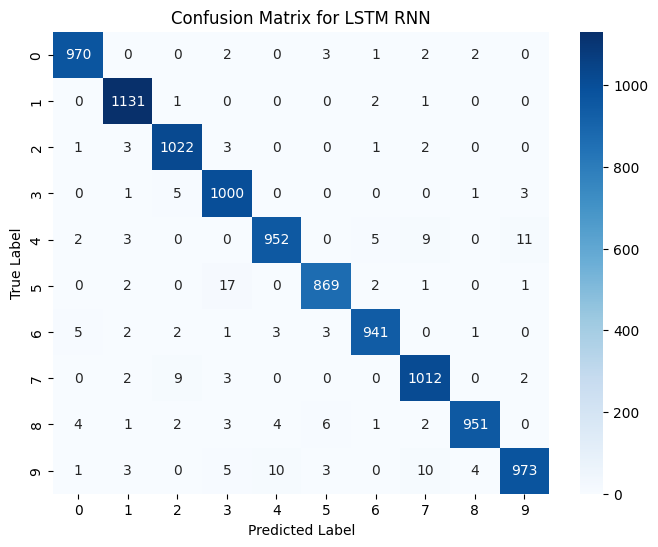

In [ ]:
display_results(rnn_type, bi_lstm_res)

Once again, the GRU performs the best and takes the least amount to be trained.

We see that the performance of a bi-directional setup is definitely better than
a uni-directional one. This is expected because of improved context captured and higher complexity.

The slightly better performance of GRUs over LSTMs might hint that exposing all the hidden state information without any control is beneficial for the MNIST dataset.

# Plotting predcitions

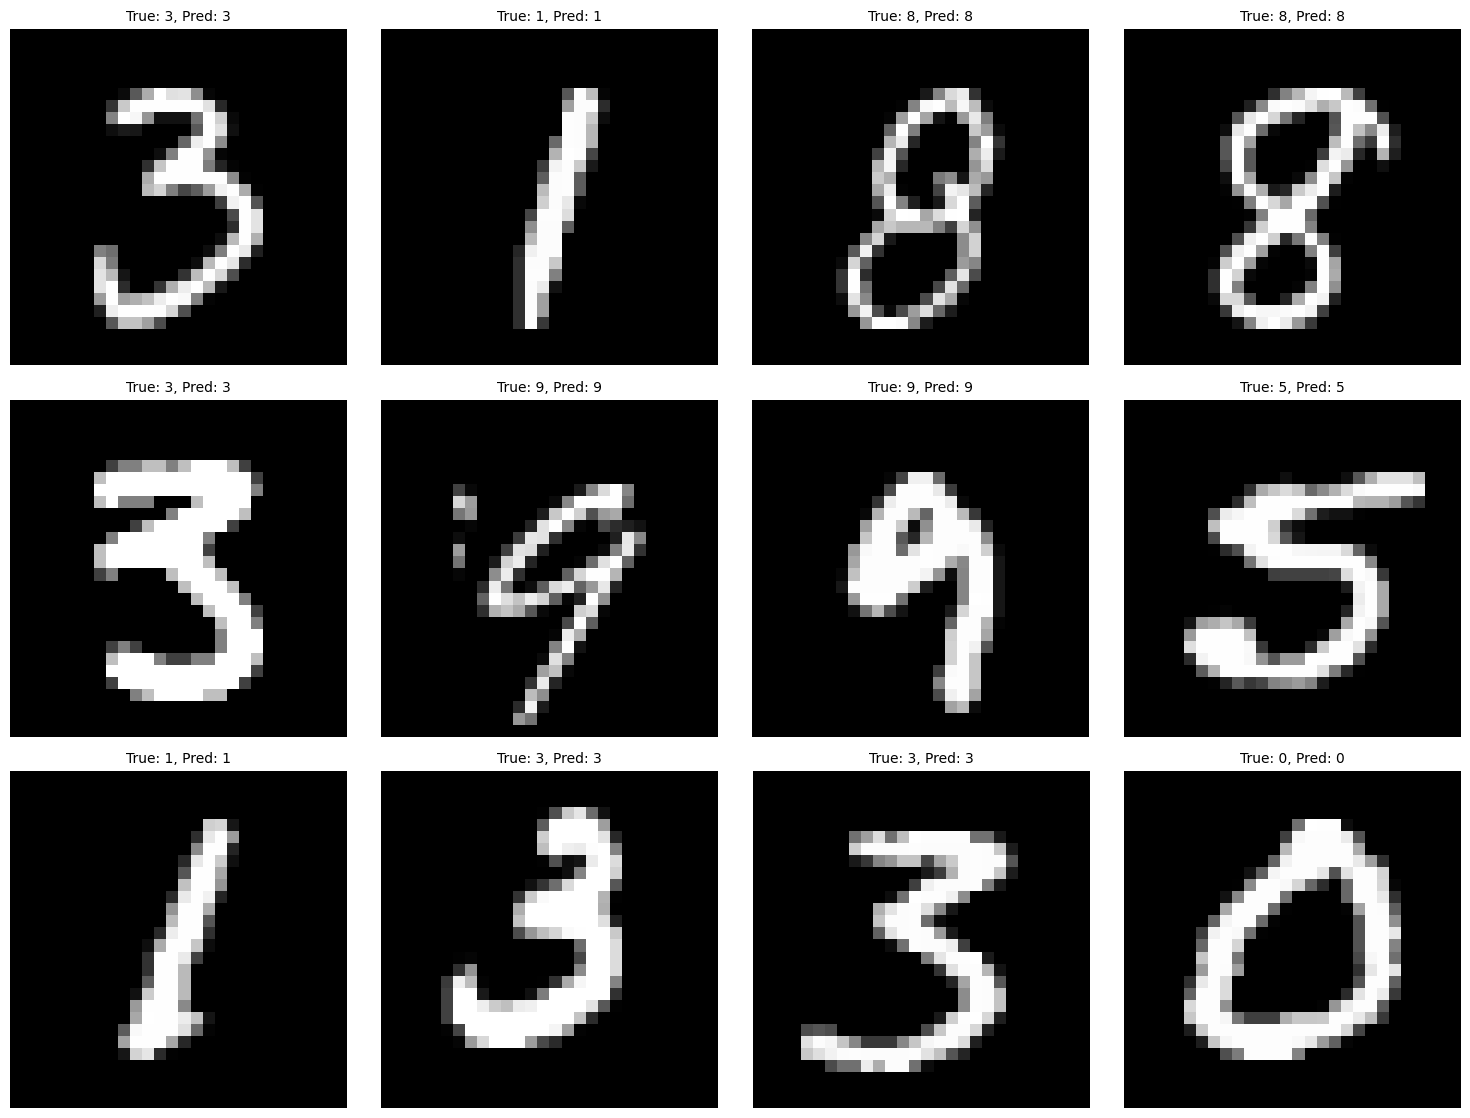

In [ ]:
top_uni_model = gru_res[-1]
top_uni_model = top_uni_model.to(device)
plot_predictions(top_uni_model, test_loader)

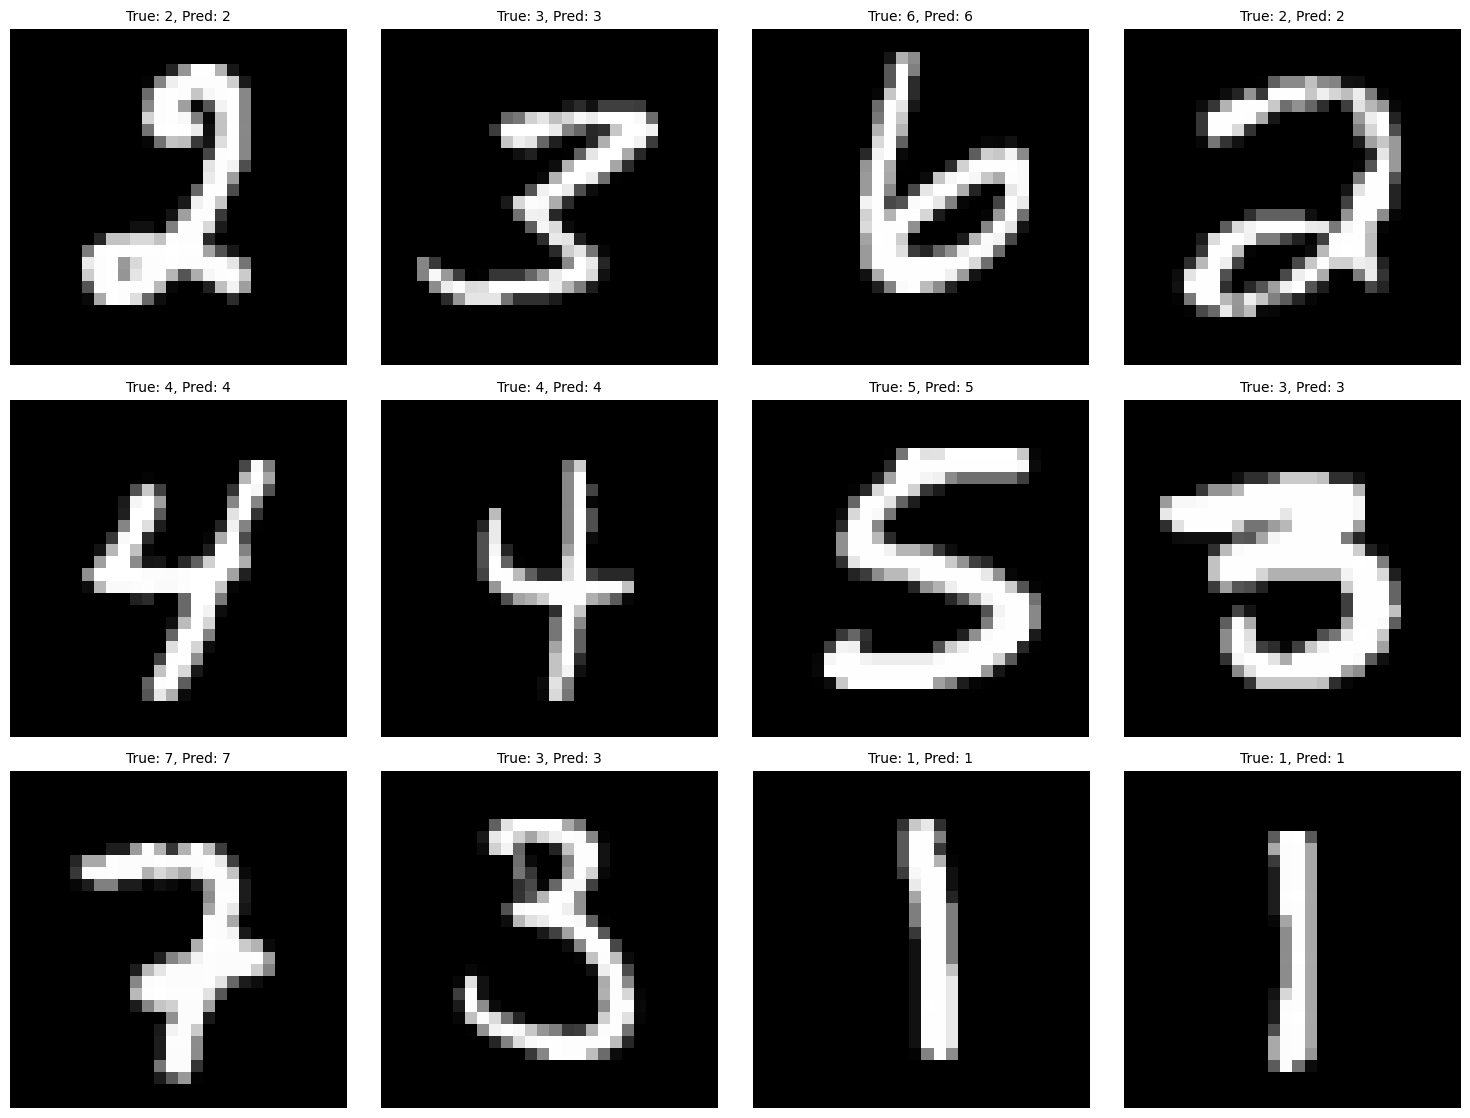

In [ ]:
top_bi_model = bi_gru_res[-1]
top_bi_model = top_bi_model.to(device)
plot_predictions(top_bi_model, test_loader)

# Predicitons on custom handwritten digits

In [ ]:
def plot_custom_images(model, images, labels, device):
    images_tensor = torch.stack([torch.Tensor(img) for img in X]).unsqueeze(1)
    labels_tensor = torch.Tensor(labels).long()
    #print(labels)

    outputs = model(images_tensor.to(device))
    #print(outputs)
    _, predictions = outputs.max(1)

    num_samples = len(images)
    grid_size = int(math.ceil(math.sqrt(num_samples)))

    plt.figure(figsize=(15, 15))
    for i, (img, label, pred) in enumerate(zip(images_tensor, labels_tensor, predictions)):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(img[0].cpu().numpy(), cmap='gray')
        plt.title(f"True: {label.item()}, Pred: {pred.item()}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (28, 28))
    img_normalized = img_resized / 255.0
    # Inverted the colors to match the MNIST format
    img_normalized = 1.0 - img_normalized
    return img_normalized

In [ ]:
# Load and preprocess your images
X = [preprocess_image(f"/content/drive/MyDrive/EE5179 DLI/Assignment3/custom_images/{i}.jpg") for i in range(10)]
y = [i for i in range(10)]

## Prediciton with GRU

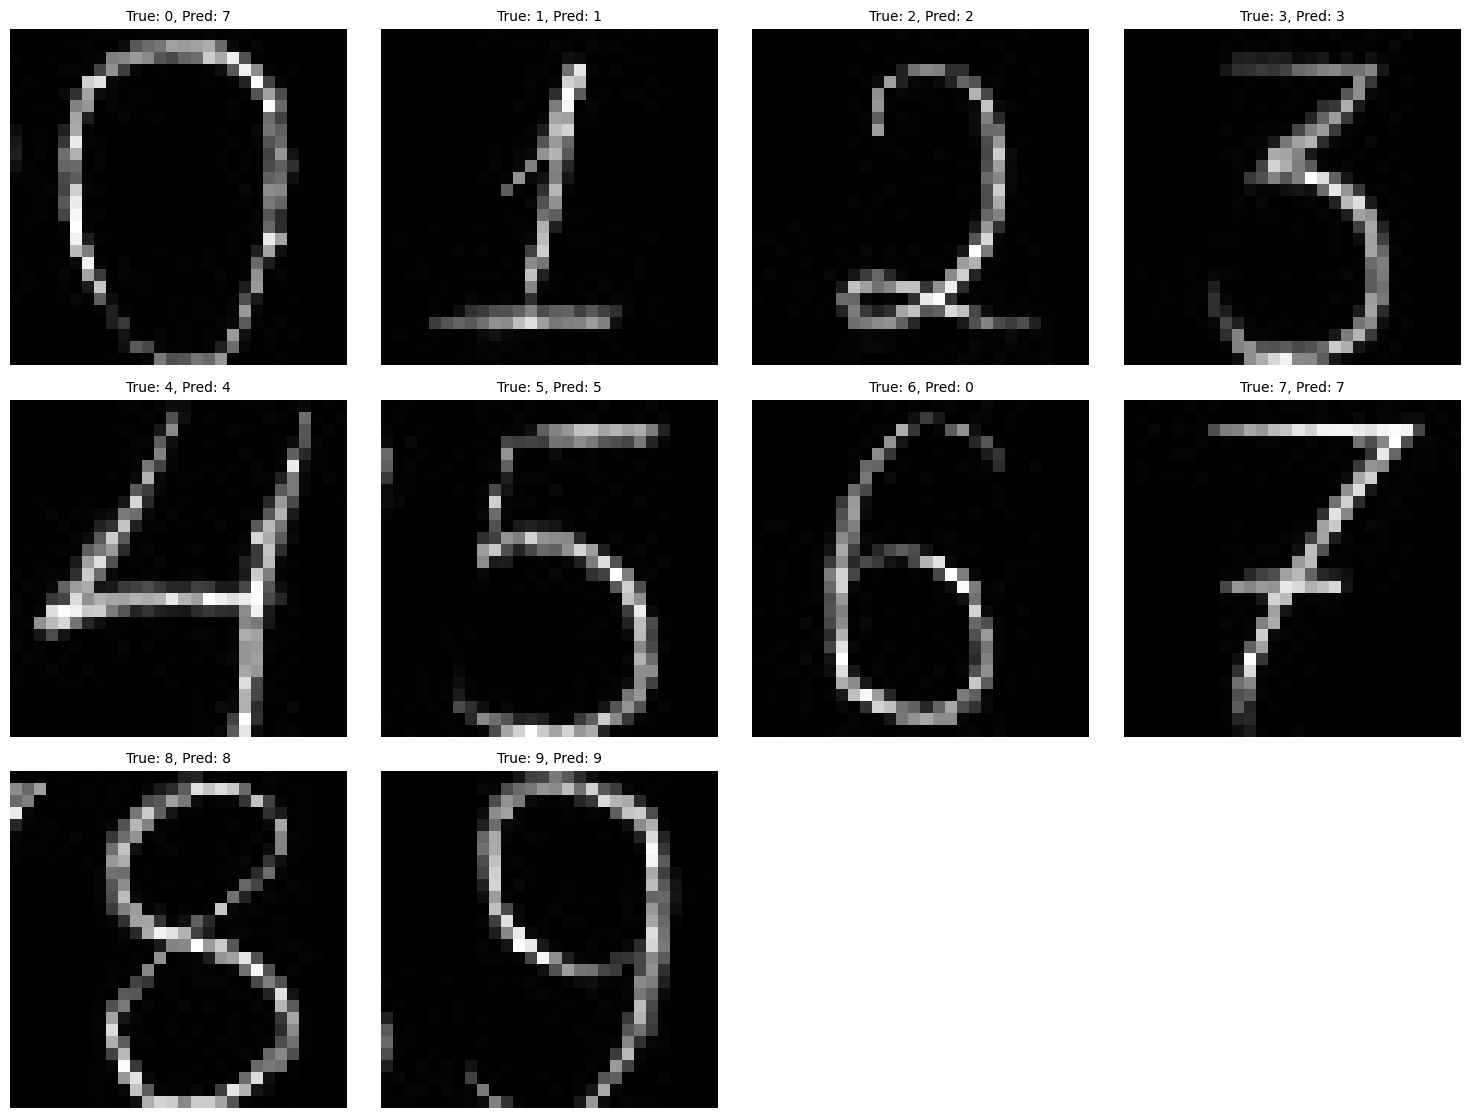

In [ ]:
plot_custom_images(top_uni_model, X, y, device)

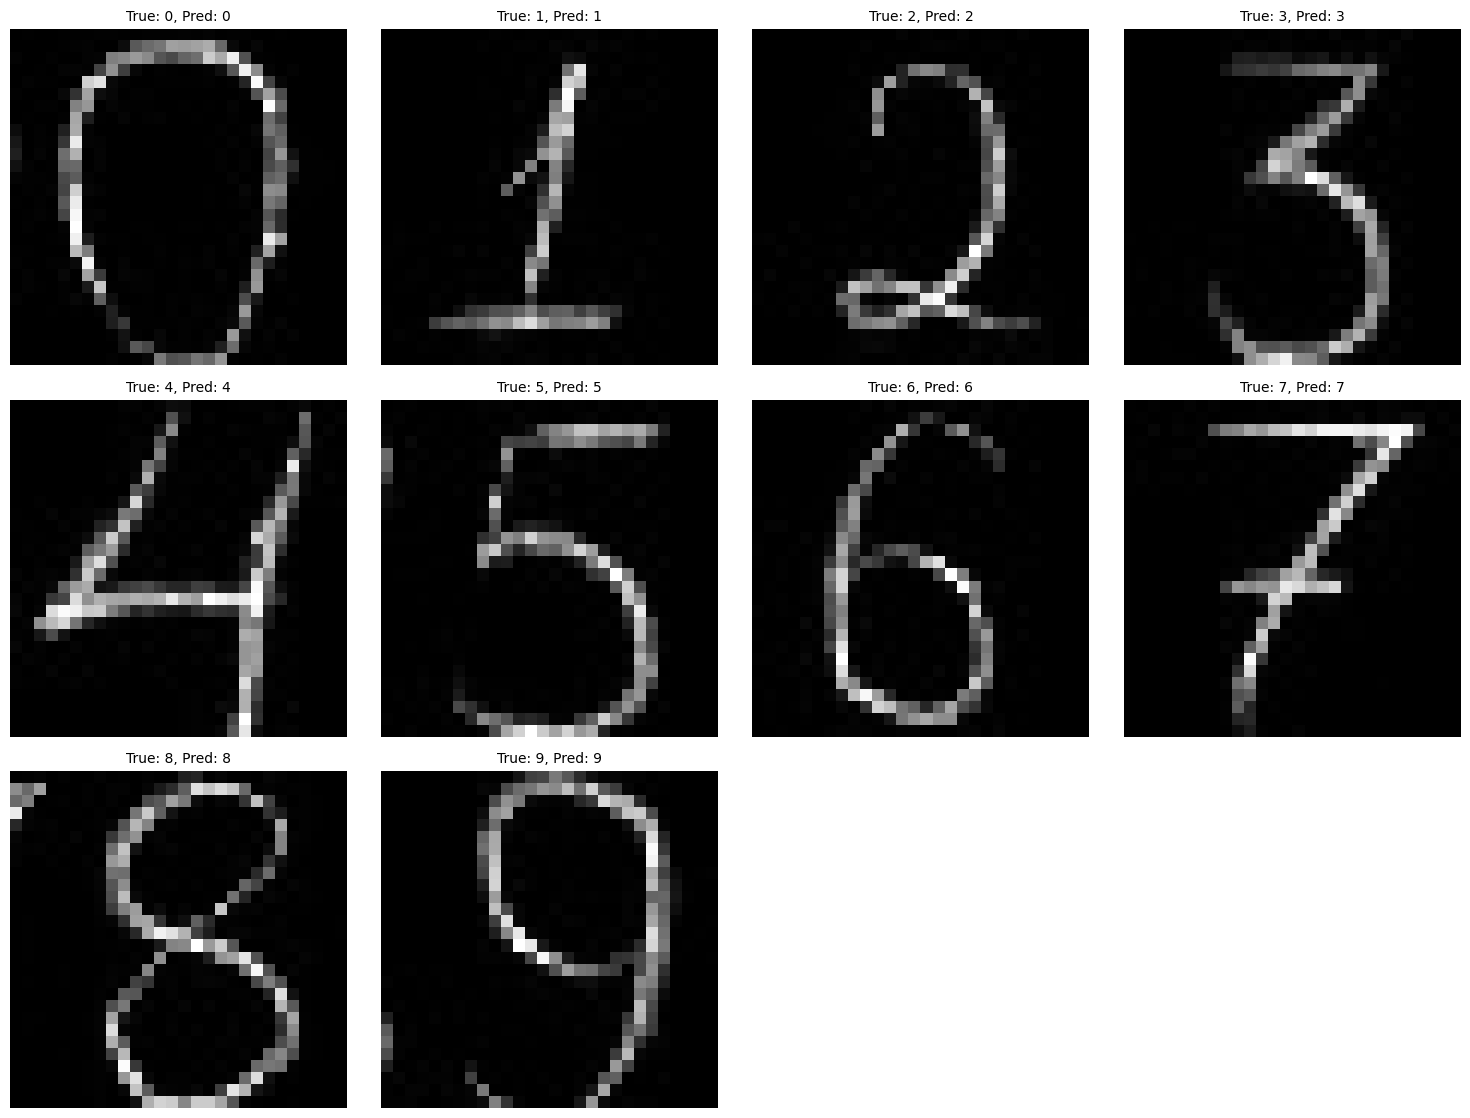

In [ ]:
plot_custom_images(top_bi_model, X, y, device)

This experiment shows the robustness of the bi-directional model, as it works well even with the custom images, which clearly have a thinner stroke than the images from the MNIST dataset.

# Teaching an RNN to learn binary addition

We'll have 5 layers in our LSTM architecture for this task and train for 5000 epochs with each hidden state size. We'll use a sequence of length 5 for each experiment as specified in the assignment.

## Function to generate data

In [4]:
def get_batch(K, L):
    max_num = (2 ** L) - 1
    X = np.zeros((K, L + 1, 2))
    y = np.zeros((K, L + 1, 1))

    for i in range(K):
        a, b = random.sample(range(max_num + 1), 2)
        c = a + b

        # Convert to padded binary strings
        a_bin = format(a, f'0{L + 1}b')
        b_bin = format(b, f'0{L + 1}b')
        c_bin = format(c, f'0{L + 1}b')

        for j in range(L + 1):
            X[i, j, 0] = int(a_bin[j])
            X[i, j, 1] = int(b_bin[j])
            y[i, j, 0] = int(c_bin[j])

    return torch.tensor(X).float(), torch.tensor(y).long()

## The LSTM Architecture

In [5]:
class BinaryAdder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        super().__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        output, (hidden, cell) = self.rnn(text)
        return self.fc(output)

## Functions to train, evaluate and plot

In [6]:
def evaluate(model, criterion, K, L):
    inputs, labels = get_batch(K, L)
    labels = labels.flatten()
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        if criterion:
            loss = criterion(outputs.view(-1, 2), labels)
        correct = (torch.argmax(outputs, dim=-1).flatten() == labels).sum().item()
        accuracy = 100 * correct / len(labels)

    if criterion:
        return loss.item(), accuracy
    else:
        return None, accuracy

In [7]:
def train_model(model, criterion, optimizer, K, L, epochs=1000):
    train_costs = []
    val_costs = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        inputs, labels = get_batch(K, L)
        labels = labels.flatten()
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 2), labels)
        loss.backward()
        optimizer.step()

        train_costs.append(loss.item())

        correct = (torch.argmax(outputs, dim=-1).flatten() == labels).sum().item()
        accuracy = 100 * correct / len(labels)
        train_acc.append(accuracy)

        val_cost, val_accuracy = evaluate(model, criterion, K, L)
        val_costs.append(val_cost)
        val_acc.append(val_accuracy)

        print(f'Epoch: {epoch}. Train Loss: {loss.item()}. Validation Accuracy: {val_accuracy}')
    return train_costs, train_acc, val_costs, val_acc

In [8]:
def plot_curves(train_costs, train_acc, val_costs, val_acc):
    plt.plot(train_costs)
    plt.plot(val_costs)
    plt.ylabel('Cost')
    plt.xlabel('epochs')
    plt.legend(['Train loss', 'Test loss'])
    plt.show()
    print(f'Train loss value after 1000 epochs: {train_costs[-1]}')
    print(f'Vaildation loss value after 1000 epochs: {val_costs[-1]}')

    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train acc', 'Test acc'])
    plt.show()
    print(f'Best Test Accuracy: {max(val_acc)}%')

In [9]:
def plot_accuracy_vs_length(model):
    acc = []
    for L in range(1, 21):
        _, accuracy = evaluate(model, None, 100, L)
        acc.append(accuracy)

    plt.plot(range(1, 21), acc)
    plt.ylabel('Accuracy')
    plt.xlabel('Sequence length - L')
    plt.title('Accuracy vs L plot')
    plt.show()

## Hyperparameter tuning

In [33]:
INPUT_DIM = 2
OUTPUT_DIM = 2
LR = 0.001
K  = 64
num_layers = [1, 3, 5]
hidden_state_sizes = [2, 5, 10]
lengths_of_input = [3, 5, 10]

best_accuracy = 0
best_model = None
best_params = None

for num_layer in num_layers:
    for hidden_state_size in hidden_state_sizes:
        for length_of_input in lengths_of_input:

            model = BinaryAdder(INPUT_DIM, hidden_state_size, OUTPUT_DIM, num_layer).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=LR)

            _, _, _, val_acc = train_model(model, criterion, optimizer, K, length_of_input)

            avg_val_acc = sum(val_acc[-10:]) / 10

            if avg_val_acc > best_accuracy:
                best_accuracy = avg_val_acc
                best_model = model
                best_params = (num_layer, hidden_state_size, length_of_input)

Streaming output truncated to the last 5000 lines.
Epoch: 0. Train Loss: 0.7377268671989441. Validation Accuracy: 49.739583333333336
Epoch: 1. Train Loss: 0.7205824851989746. Validation Accuracy: 49.739583333333336
Epoch: 2. Train Loss: 0.7004799246788025. Validation Accuracy: 48.4375
Epoch: 3. Train Loss: 0.7569630742073059. Validation Accuracy: 47.395833333333336
Epoch: 4. Train Loss: 0.7294548153877258. Validation Accuracy: 50.78125
Epoch: 5. Train Loss: 0.7245316505432129. Validation Accuracy: 53.125
Epoch: 6. Train Loss: 0.7213378548622131. Validation Accuracy: 50.260416666666664
Epoch: 7. Train Loss: 0.7266207337379456. Validation Accuracy: 47.916666666666664
Epoch: 8. Train Loss: 0.7419173717498779. Validation Accuracy: 48.4375
Epoch: 9. Train Loss: 0.7342092990875244. Validation Accuracy: 47.65625
Epoch: 10. Train Loss: 0.7421014308929443. Validation Accuracy: 48.958333333333336
Epoch: 11. Train Loss: 0.7387790679931641. Validation Accuracy: 51.302083333333336
Epoch: 12. Train 

In [34]:
print(f"Best Parameters: Num Layers: {best_params[0]}, Hidden State Size: {best_params[1]}, Length of Input: {best_params[2]}")
print(f"Best Validation Accuracy: {best_accuracy}")

Best Parameters: Num Layers: 3, Hidden State Size: 5, Length of Input: 3
Best Validation Accuracy: 76.328125


We'll use 3 layers for our experiments going ahead.

## Common Hyperparameters and model setup

In [54]:
INPUT_DIM = 2
OUTPUT_DIM = 2
NUM_LAYERS = 3
LR = 0.001
K = 64

## Length of Input Sequence = 5

In [55]:
L = 5

### Hidden State Size  = 2

In [56]:
HIDDEN_DIM = 2

In [57]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [58]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.6957761645317078. Validation Accuracy: 50.0
Epoch: 1. Train Loss: 0.703092634677887. Validation Accuracy: 47.65625
Epoch: 2. Train Loss: 0.6923783421516418. Validation Accuracy: 54.6875
Epoch: 3. Train Loss: 0.6939404606819153. Validation Accuracy: 50.0
Epoch: 4. Train Loss: 0.7003850340843201. Validation Accuracy: 52.083333333333336
Epoch: 5. Train Loss: 0.6947600841522217. Validation Accuracy: 52.34375
Epoch: 6. Train Loss: 0.6980153918266296. Validation Accuracy: 49.739583333333336
Epoch: 7. Train Loss: 0.6931083798408508. Validation Accuracy: 49.21875
Epoch: 8. Train Loss: 0.6992072463035583. Validation Accuracy: 51.041666666666664
Epoch: 9. Train Loss: 0.6934331059455872. Validation Accuracy: 48.697916666666664
Epoch: 10. Train Loss: 0.6988725662231445. Validation Accuracy: 50.260416666666664
Epoch: 11. Train Loss: 0.7001850008964539. Validation Accuracy: 51.822916666666664
Epoch: 12. Train Loss: 0.7016766667366028. Validation Accuracy: 48.958333333333336
E

#### Train and test plots

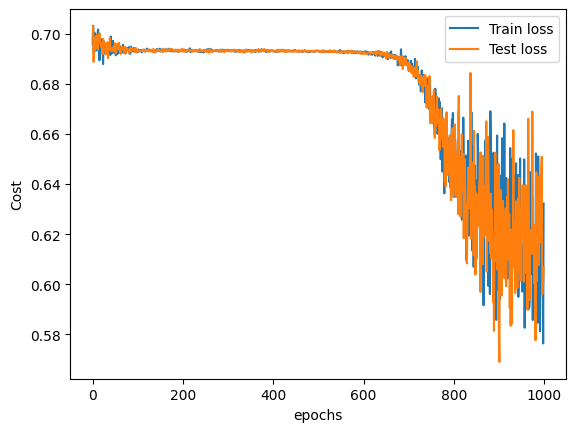

Train loss value after 1000 epochs: 0.6322546601295471
Vaildation loss value after 1000 epochs: 0.606839120388031


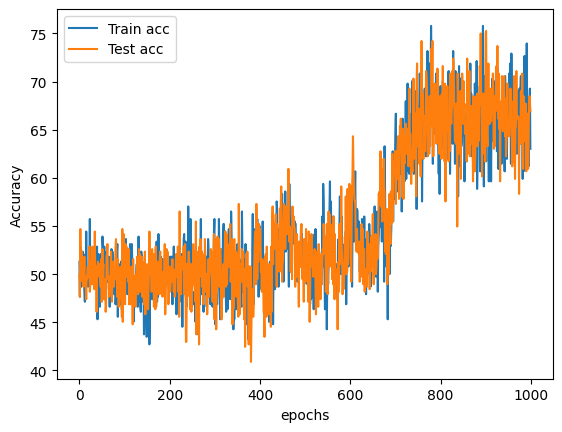

Best Test Accuracy: 75.26041666666667%


In [59]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

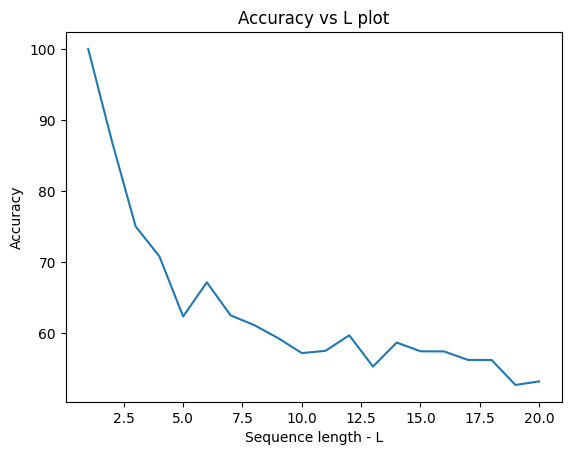

In [60]:
plot_accuracy_vs_length(model)

### Hidden State Size = 5

In [61]:
HIDDEN_DIM = 5

In [62]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [63]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.6913638710975647. Validation Accuracy: 48.697916666666664
Epoch: 1. Train Loss: 0.6915282607078552. Validation Accuracy: 50.520833333333336
Epoch: 2. Train Loss: 0.6957070827484131. Validation Accuracy: 52.083333333333336
Epoch: 3. Train Loss: 0.6964725852012634. Validation Accuracy: 48.958333333333336
Epoch: 4. Train Loss: 0.6935638785362244. Validation Accuracy: 52.864583333333336
Epoch: 5. Train Loss: 0.7013599872589111. Validation Accuracy: 52.34375
Epoch: 6. Train Loss: 0.6942768692970276. Validation Accuracy: 49.739583333333336
Epoch: 7. Train Loss: 0.6922513842582703. Validation Accuracy: 52.604166666666664
Epoch: 8. Train Loss: 0.6884399056434631. Validation Accuracy: 51.041666666666664
Epoch: 9. Train Loss: 0.692714512348175. Validation Accuracy: 50.0
Epoch: 10. Train Loss: 0.6895633339881897. Validation Accuracy: 50.0
Epoch: 11. Train Loss: 0.6899054050445557. Validation Accuracy: 51.822916666666664
Epoch: 12. Train Loss: 0.6956167817115784. Validation

#### Train and test plots

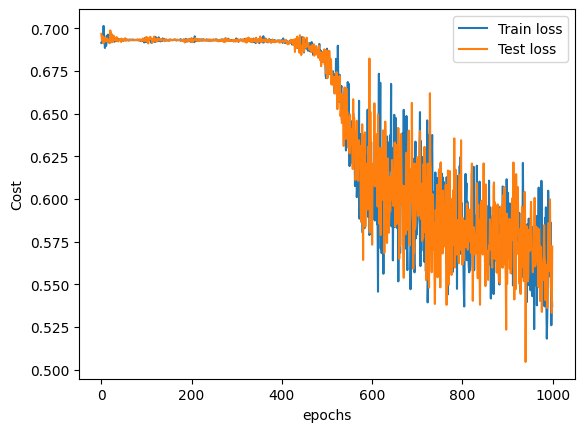

Train loss value after 1000 epochs: 0.5373022556304932
Vaildation loss value after 1000 epochs: 0.572155237197876


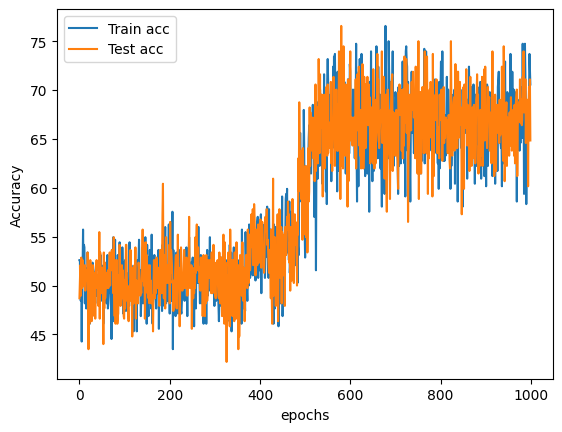

Best Test Accuracy: 76.5625%


In [64]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

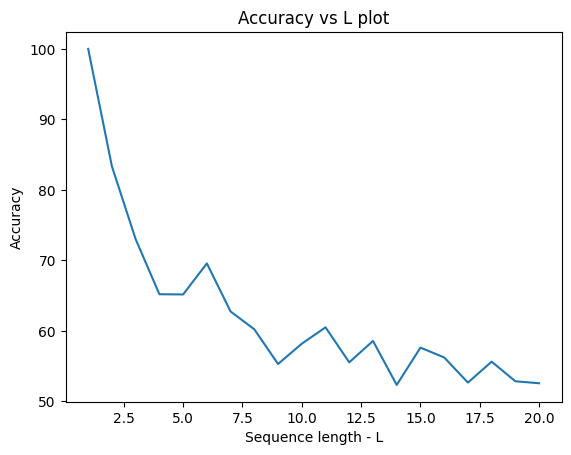

In [65]:
plot_accuracy_vs_length(model)

### Hidden State Size = 10

In [66]:
HIDDEN_DIM = 10

In [67]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [68]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.6988318562507629. Validation Accuracy: 48.697916666666664
Epoch: 1. Train Loss: 0.6959030628204346. Validation Accuracy: 49.479166666666664
Epoch: 2. Train Loss: 0.6925856471061707. Validation Accuracy: 51.822916666666664
Epoch: 3. Train Loss: 0.6948150992393494. Validation Accuracy: 52.604166666666664
Epoch: 4. Train Loss: 0.6923754215240479. Validation Accuracy: 50.520833333333336
Epoch: 5. Train Loss: 0.6975924372673035. Validation Accuracy: 44.791666666666664
Epoch: 6. Train Loss: 0.6995091438293457. Validation Accuracy: 51.302083333333336
Epoch: 7. Train Loss: 0.6935998797416687. Validation Accuracy: 50.78125
Epoch: 8. Train Loss: 0.7013750672340393. Validation Accuracy: 48.958333333333336
Epoch: 9. Train Loss: 0.6939648985862732. Validation Accuracy: 50.0
Epoch: 10. Train Loss: 0.6920711398124695. Validation Accuracy: 52.083333333333336
Epoch: 11. Train Loss: 0.6928055882453918. Validation Accuracy: 50.0
Epoch: 12. Train Loss: 0.6951730251312256. Validatio

#### Train and test plots

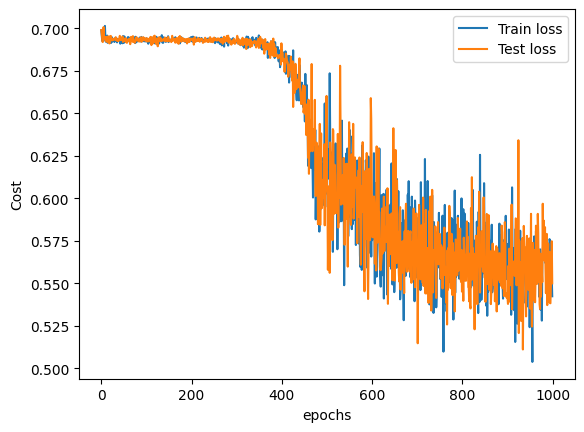

Train loss value after 1000 epochs: 0.542336642742157
Vaildation loss value after 1000 epochs: 0.5499600768089294


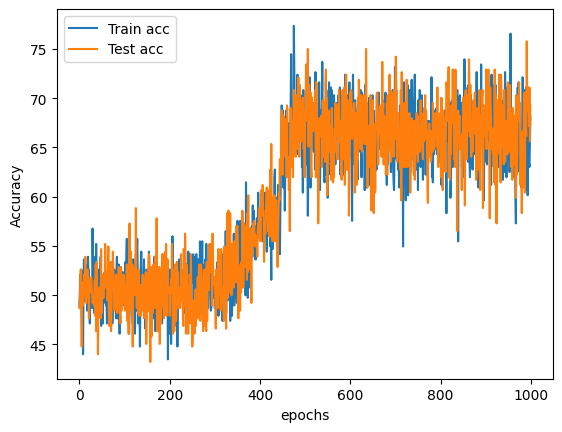

Best Test Accuracy: 75.78125%


In [69]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

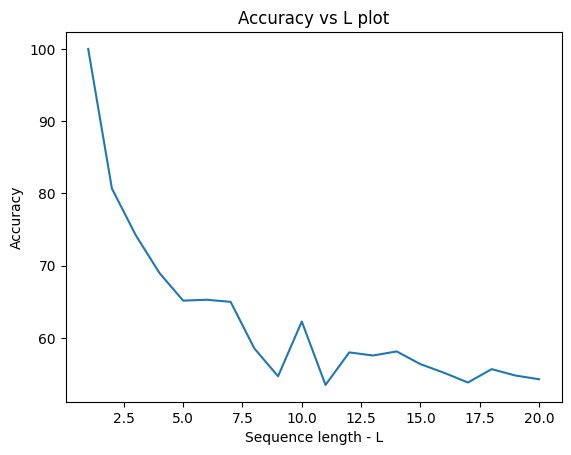

In [70]:
plot_accuracy_vs_length(model)

### Summary of Results

Sequence length = 5

Epochs for training = 1000

State Size | Train loss | Validation Loss | Bitwise Accuracy |
-------------------|------------------|---------------|-------------|
      2 |  0.6322 |  0.6068  | 75.26% |
        5 | 0.5373 | 0.5721  | 76.56% |
       10 |  0.5423| 0.55  |  75.78% |

The performance is comparable but it seems like a hidden state size of 5 or 10 is more ideal. We might discover a trend when we try with other binary string lengths.

Analyzing the relationship between sequence lengths and bitwise accuracy from the plots, there's a noticeable decline in performance with increasing sequence lengths. This performance degradation becomes more pronounced for sequences longer than the ones used during training (in this instance, sequences of length 5). An accuracy nearing 50% isn't commendable for this task. Given that the input consists of binary strings, where the model essentially has to "predict" either 0 or 1, an accuracy of 50% implies that the model is performing no better than random guessing.

## Length of Input Sequence =  3

In [82]:
L = 3

### Hidden State Size  = 2

In [98]:
HIDDEN_DIM = 2

In [99]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [100]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.7047699093818665. Validation Accuracy: 51.953125
Epoch: 1. Train Loss: 0.7034203410148621. Validation Accuracy: 51.5625
Epoch: 2. Train Loss: 0.6994909644126892. Validation Accuracy: 51.5625
Epoch: 3. Train Loss: 0.6980426907539368. Validation Accuracy: 49.609375
Epoch: 4. Train Loss: 0.7078401446342468. Validation Accuracy: 50.390625
Epoch: 5. Train Loss: 0.705805242061615. Validation Accuracy: 46.875
Epoch: 6. Train Loss: 0.6986811757087708. Validation Accuracy: 50.390625
Epoch: 7. Train Loss: 0.6914618015289307. Validation Accuracy: 48.4375
Epoch: 8. Train Loss: 0.6968361139297485. Validation Accuracy: 50.0
Epoch: 9. Train Loss: 0.6901028156280518. Validation Accuracy: 49.21875
Epoch: 10. Train Loss: 0.6977769136428833. Validation Accuracy: 53.515625
Epoch: 11. Train Loss: 0.6968796849250793. Validation Accuracy: 47.265625
Epoch: 12. Train Loss: 0.6984935998916626. Validation Accuracy: 50.78125
Epoch: 13. Train Loss: 0.701556384563446. Validation Accuracy: 46

#### Train and test plots

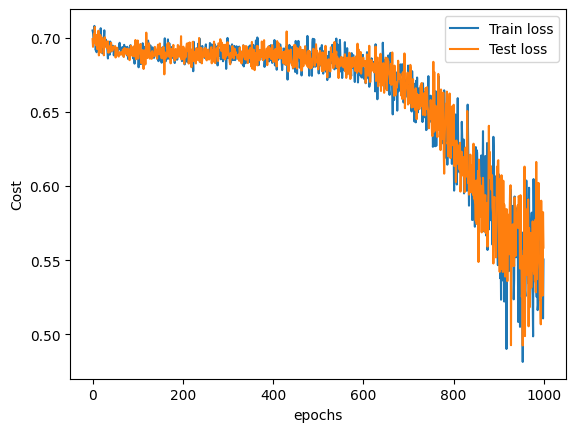

Train loss value after 1000 epochs: 0.5504103302955627
Vaildation loss value after 1000 epochs: 0.5584276914596558


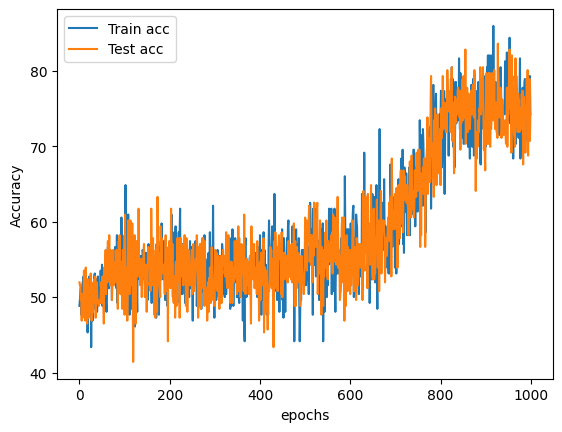

Best Test Accuracy: 83.59375%


In [101]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

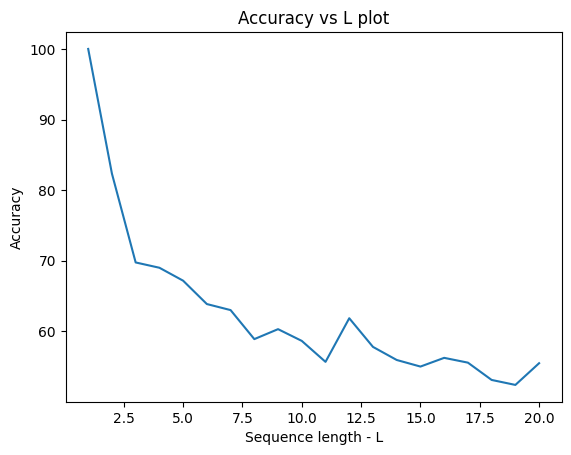

In [102]:
plot_accuracy_vs_length(model)

### Hidden State Size  = 5

In [103]:
HIDDEN_DIM = 5

In [104]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [105]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.696895182132721. Validation Accuracy: 49.609375
Epoch: 1. Train Loss: 0.6937692165374756. Validation Accuracy: 46.875
Epoch: 2. Train Loss: 0.6918464303016663. Validation Accuracy: 50.78125
Epoch: 3. Train Loss: 0.6944811940193176. Validation Accuracy: 50.78125
Epoch: 4. Train Loss: 0.6939907670021057. Validation Accuracy: 49.21875
Epoch: 5. Train Loss: 0.693337619304657. Validation Accuracy: 49.609375
Epoch: 6. Train Loss: 0.6939125061035156. Validation Accuracy: 46.875
Epoch: 7. Train Loss: 0.6904668211936951. Validation Accuracy: 51.5625
Epoch: 8. Train Loss: 0.6916535496711731. Validation Accuracy: 48.4375
Epoch: 9. Train Loss: 0.6915280222892761. Validation Accuracy: 51.171875
Epoch: 10. Train Loss: 0.6915940642356873. Validation Accuracy: 49.21875
Epoch: 11. Train Loss: 0.6930185556411743. Validation Accuracy: 52.34375
Epoch: 12. Train Loss: 0.6902339458465576. Validation Accuracy: 54.6875
Epoch: 13. Train Loss: 0.6932101845741272. Validation Accuracy: 46.

#### Train and test plots

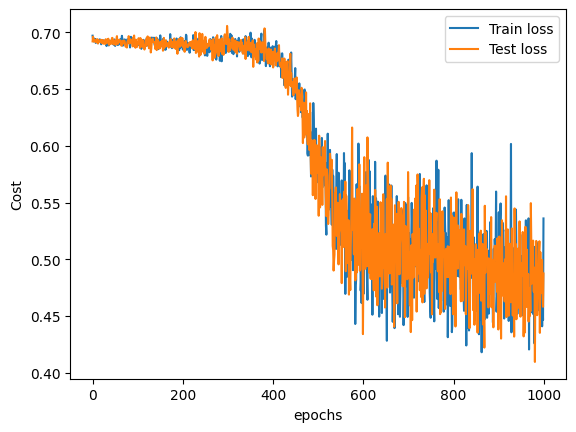

Train loss value after 1000 epochs: 0.5359713435173035
Vaildation loss value after 1000 epochs: 0.4874132573604584


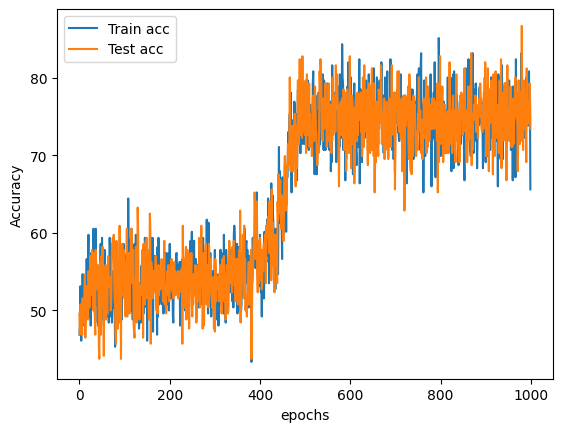

Best Test Accuracy: 86.71875%


In [106]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

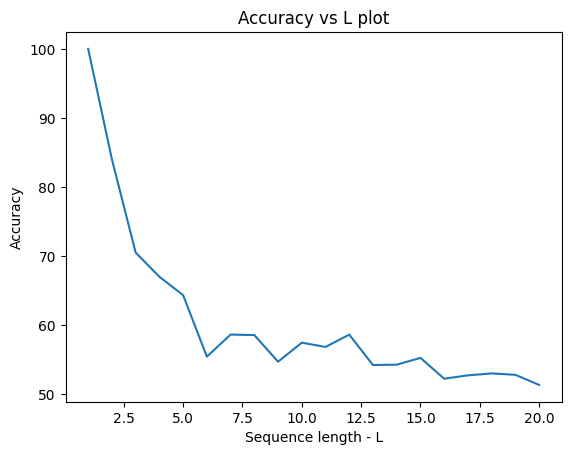

In [107]:
plot_accuracy_vs_length(model)

### Hidden State Size  = 10

In [108]:
HIDDEN_DIM = 10

In [109]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [110]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.7030448317527771. Validation Accuracy: 53.125
Epoch: 1. Train Loss: 0.6959405541419983. Validation Accuracy: 52.734375
Epoch: 2. Train Loss: 0.6992778182029724. Validation Accuracy: 48.828125
Epoch: 3. Train Loss: 0.6988399028778076. Validation Accuracy: 50.0
Epoch: 4. Train Loss: 0.6958133578300476. Validation Accuracy: 51.171875
Epoch: 5. Train Loss: 0.6981773972511292. Validation Accuracy: 50.390625
Epoch: 6. Train Loss: 0.703985869884491. Validation Accuracy: 49.21875
Epoch: 7. Train Loss: 0.6964614987373352. Validation Accuracy: 51.171875
Epoch: 8. Train Loss: 0.705502986907959. Validation Accuracy: 50.390625
Epoch: 9. Train Loss: 0.6939699053764343. Validation Accuracy: 50.0
Epoch: 10. Train Loss: 0.6949734687805176. Validation Accuracy: 52.734375
Epoch: 11. Train Loss: 0.6996622681617737. Validation Accuracy: 50.390625
Epoch: 12. Train Loss: 0.6976218819618225. Validation Accuracy: 51.5625
Epoch: 13. Train Loss: 0.6888226270675659. Validation Accuracy: 47

#### Train and test plots

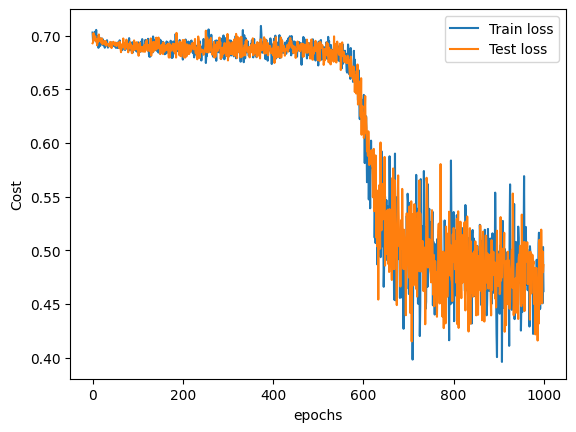

Train loss value after 1000 epochs: 0.4619201421737671
Vaildation loss value after 1000 epochs: 0.48619815707206726


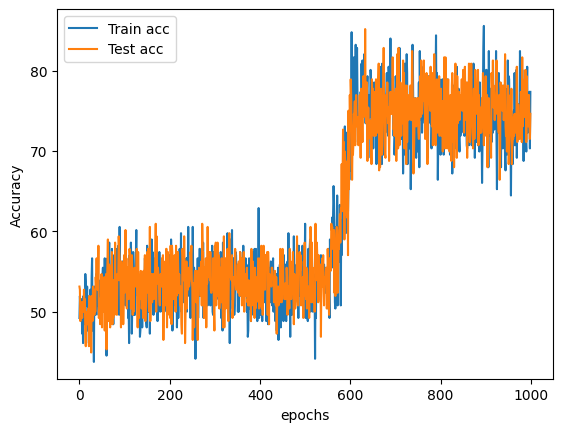

Best Test Accuracy: 85.15625%


In [111]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

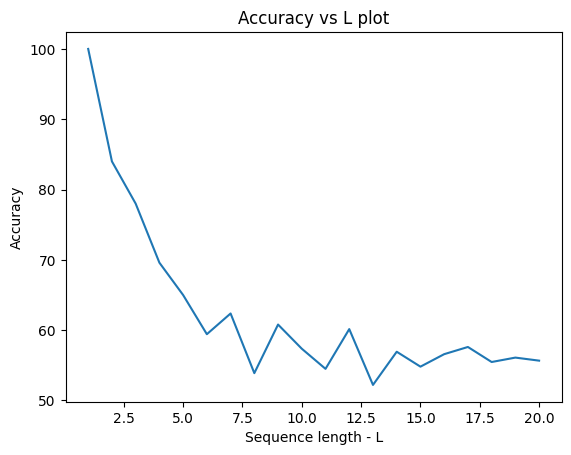

In [112]:
plot_accuracy_vs_length(model)

### Summary of Results

Sequence length = 3

Epochs for training = 1000


State Size | Train loss | Validation Loss | Bitwise Accuracy |
-------------------|------------------|---------------|-------------|
      2 |  0.5504 |  0.5584 | 83.59375% |
        5 | 0.5359 | 0.4874  | 86.71875% |
       10 |  0.4619| 0.4861  |  85.15625% |

The performance is comparable but it seems like a hidden state size of 5 or 10 is more ideal. We might discover a trend when we try with other binary string lengths.

Analyzing the relationship between sequence lengths and bitwise accuracy from the plots, there's a noticeable decline in performance with increasing sequence lengths.

A noteworthy observation is that our training has been limited to sequences of lengths 3 and 5. In both instances, the bitwise accuracy drops to below 60% around sequence lengths of 5-6. This suggests that models trained on shorter sequences can generalize as effectively as those trained on longer sequences when tasked with processing extended strings, provided the architecture remains consistent and sufficient training epochs are utilized.

## Length of Input Sequence = 10

In [131]:
L = 10

### Hidden State Size  = 2

In [132]:
HIDDEN_DIM = 2

In [133]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [134]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.7343868017196655. Validation Accuracy: 50.71022727272727
Epoch: 1. Train Loss: 0.7355112433433533. Validation Accuracy: 48.57954545454545
Epoch: 2. Train Loss: 0.7161359190940857. Validation Accuracy: 50.28409090909091
Epoch: 3. Train Loss: 0.7154760360717773. Validation Accuracy: 48.86363636363637
Epoch: 4. Train Loss: 0.7339316010475159. Validation Accuracy: 49.43181818181818
Epoch: 5. Train Loss: 0.744961142539978. Validation Accuracy: 47.72727272727273
Epoch: 6. Train Loss: 0.7304225564002991. Validation Accuracy: 47.86931818181818
Epoch: 7. Train Loss: 0.7311573028564453. Validation Accuracy: 50.42613636363637
Epoch: 8. Train Loss: 0.7293918132781982. Validation Accuracy: 47.86931818181818
Epoch: 9. Train Loss: 0.7251937389373779. Validation Accuracy: 48.15340909090909
Epoch: 10. Train Loss: 0.7048021554946899. Validation Accuracy: 50.0
Epoch: 11. Train Loss: 0.7375755310058594. Validation Accuracy: 50.56818181818182
Epoch: 12. Train Loss: 0.706967711448669

#### Train and test plots

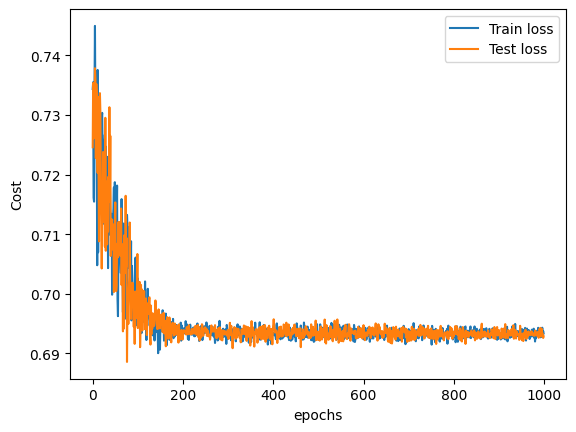

Train loss value after 1000 epochs: 0.6933560967445374
Vaildation loss value after 1000 epochs: 0.6928938031196594


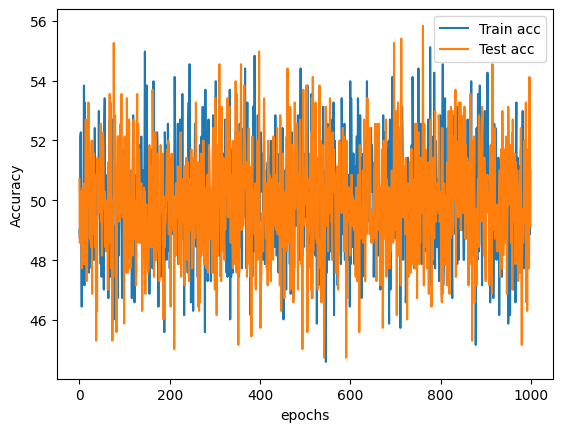

Best Test Accuracy: 55.82386363636363%


In [135]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

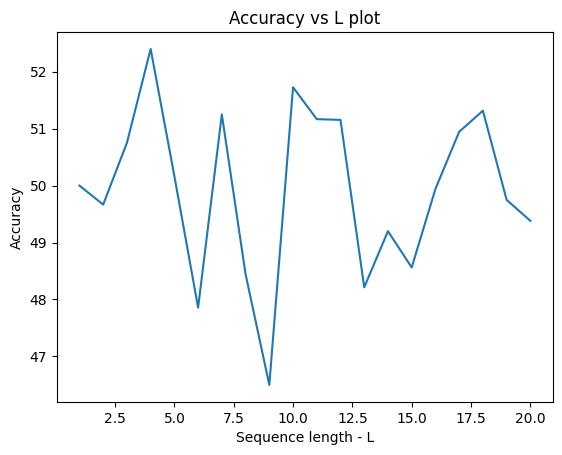

In [136]:
plot_accuracy_vs_length(model)

### Hidden State Size  = 5

In [137]:
HIDDEN_DIM = 5

In [138]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [139]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.697051465511322. Validation Accuracy: 51.27840909090909
Epoch: 1. Train Loss: 0.6988427639007568. Validation Accuracy: 50.0
Epoch: 2. Train Loss: 0.6985238790512085. Validation Accuracy: 46.875
Epoch: 3. Train Loss: 0.6989428997039795. Validation Accuracy: 50.0
Epoch: 4. Train Loss: 0.6962623000144958. Validation Accuracy: 49.57386363636363
Epoch: 5. Train Loss: 0.6904205083847046. Validation Accuracy: 50.14204545454545
Epoch: 6. Train Loss: 0.6965134143829346. Validation Accuracy: 47.86931818181818
Epoch: 7. Train Loss: 0.6944434642791748. Validation Accuracy: 51.42045454545455
Epoch: 8. Train Loss: 0.6952310800552368. Validation Accuracy: 50.71022727272727
Epoch: 9. Train Loss: 0.697242796421051. Validation Accuracy: 54.26136363636363
Epoch: 10. Train Loss: 0.6957153677940369. Validation Accuracy: 51.27840909090909
Epoch: 11. Train Loss: 0.6966599822044373. Validation Accuracy: 50.28409090909091
Epoch: 12. Train Loss: 0.6960803866386414. Validation Accuracy: 5

#### Train and test plots

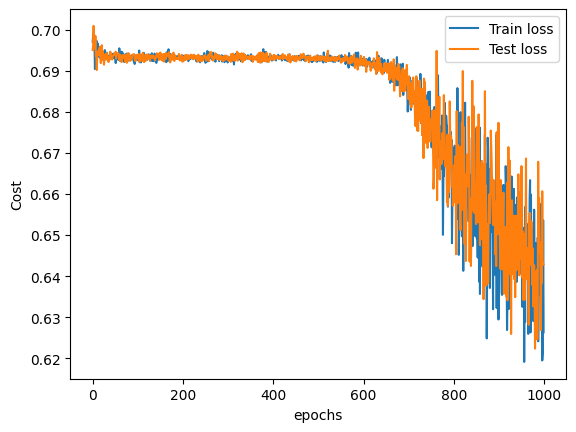

Train loss value after 1000 epochs: 0.6263185143470764
Vaildation loss value after 1000 epochs: 0.6428563594818115


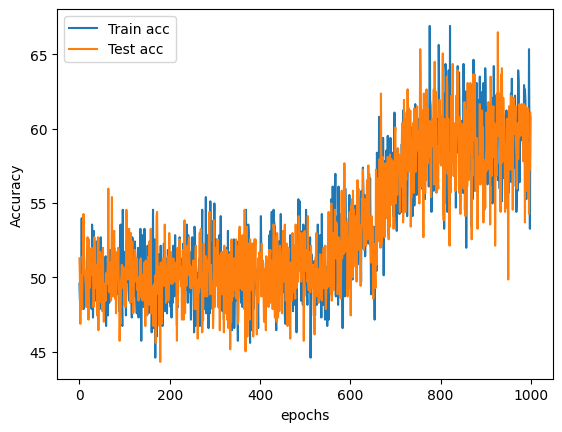

Best Test Accuracy: 66.47727272727273%


In [140]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

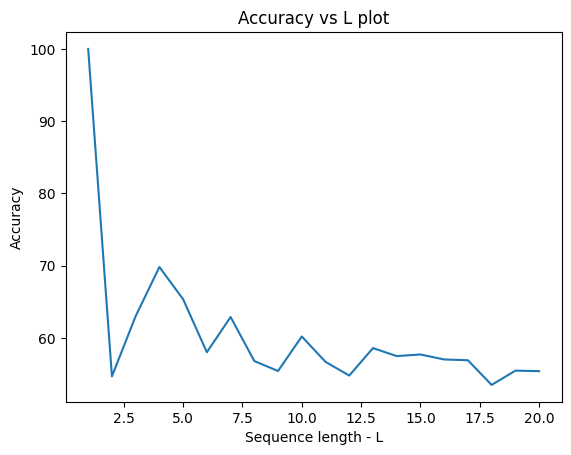

In [141]:
plot_accuracy_vs_length(model)

### Hidden State Size  = 10

In [142]:
HIDDEN_DIM = 10

In [143]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [144]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.6963188648223877. Validation Accuracy: 50.71022727272727
Epoch: 1. Train Loss: 0.6934484839439392. Validation Accuracy: 48.72159090909091
Epoch: 2. Train Loss: 0.6949735283851624. Validation Accuracy: 50.42613636363637
Epoch: 3. Train Loss: 0.6926169991493225. Validation Accuracy: 49.71590909090909
Epoch: 4. Train Loss: 0.6951655149459839. Validation Accuracy: 47.72727272727273
Epoch: 5. Train Loss: 0.6935188174247742. Validation Accuracy: 52.69886363636363
Epoch: 6. Train Loss: 0.6924707293510437. Validation Accuracy: 48.72159090909091
Epoch: 7. Train Loss: 0.6929764151573181. Validation Accuracy: 52.41477272727273
Epoch: 8. Train Loss: 0.6924092769622803. Validation Accuracy: 51.42045454545455
Epoch: 9. Train Loss: 0.6931347250938416. Validation Accuracy: 49.71590909090909
Epoch: 10. Train Loss: 0.6938812732696533. Validation Accuracy: 53.55113636363637
Epoch: 11. Train Loss: 0.6930593252182007. Validation Accuracy: 50.56818181818182
Epoch: 12. Train Loss: 0.6

#### Train and test plots

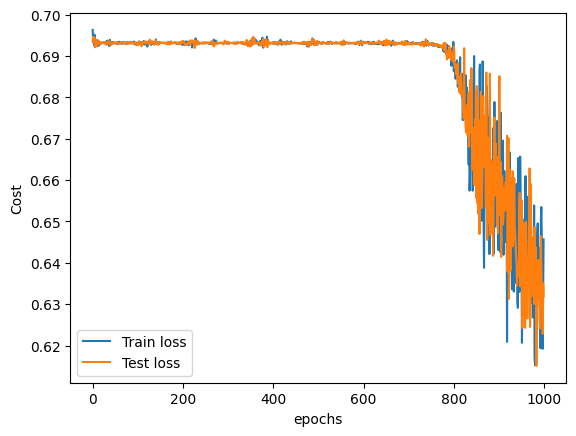

Train loss value after 1000 epochs: 0.645656943321228
Vaildation loss value after 1000 epochs: 0.631892204284668


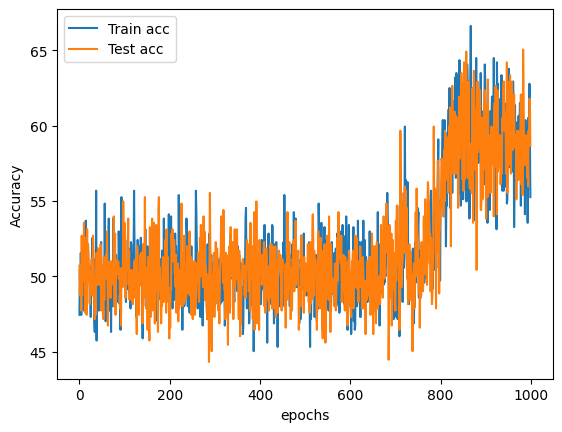

Best Test Accuracy: 65.05681818181819%


In [145]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

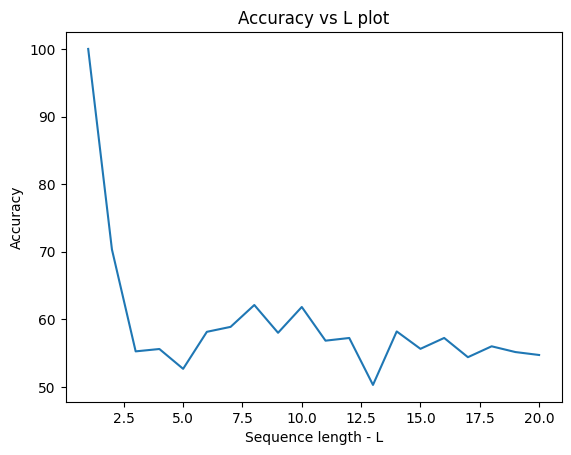

In [146]:
plot_accuracy_vs_length(model)

### Summary of Results

Sequence length = 10

Epochs for training = 1000

Train loss value after 1000 epochs: 0.645656943321228
Vaildation loss value after 1000 epochs: 0.631892204284668


State Size | Train loss | Validation Loss | Bitwise Accuracy |
-------------------|------------------|---------------|-------------|
      2 |  0.6933 |  0.6928 | 55.8238% |
        5 | 0.6263 | 0.6428  | 66.4772% |
       10 |  0.6456 | 0.6319  |  65.0568% |

In our previous experiments, we observed that the model struggles with learning the task for longer strings. For this study, we specifically trained and tested it on sequences of length 10. I think this problem arises due to issues other than the choice of arhcitecture (like vanishing gradients), hyperparameters or the amount of data. The inherent complexity of the task becomes evident when considering the "carry" context in numerical operations. For instance, the sum of 1+1 can result in either 0 or 1 depending on the carry from a previous position. Similarly, 0+0 and 0+1 can also produce varying results based on the carry. This contextual understanding of the carry appears to be the primary challenge for the model.

## Overall Summary

Sequence Length | State Size | Bitwise Accuracy |
-------------------|------------------|---------------|
      3 | 2 |  83.59375%  |
        3 | 5 | 86.71875% |
       3 | 10 | 85.15625% |
       5 | 2 | 75.26% |
       5 | 5 | 76.56% |
       5 | 10 | 75.78% |
       10 | 2 | 55.88238% |
       10 | 5 | 66.4772% |
       10 | 10 | 65.0568% |


 Here are some key observations and inferences:

* A hidden state size of 5 seems to be ideal, as seen from all the experiments.   
*   The performance of the model decreases with increase in the length of the string.
*  This decrease is apparent in all experiments and is almost agnostic of length of the sequences on which the model was trained.
* The model finds it tricky to interpret the concept of carry as the length of the srting increases.



## Comparison with MSE
We test on an architecture with 3 LSTM layers and hidden state size of 5.

In [19]:
class BinaryAdder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers = 1):
        super().__init__()
        self.layers = layers
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers = layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        output, (hidden, cell) = self.rnn(text)
        return F.softmax(self.fc(output), dim = -1)

In [20]:
def one_hot_encode(labels, num_classes=2):
    # Convert labels to one-hot encoded tensor
    return F.one_hot(labels, num_classes=num_classes).float()

def evaluate(model, criterion, K, L):
    inputs, labels = get_batch(K, L)
    labels = one_hot_encode(labels.flatten())
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        if criterion:
            loss = criterion(outputs.view(-1, 2), labels)
        correct = (torch.argmax(outputs, dim=-1).flatten() == torch.argmax(labels, dim=-1)).sum().item()
        accuracy = 100 * correct / len(labels)

    if criterion:
        return loss.item(), accuracy
    else:
        return None, accuracy

def train_model(model, criterion, optimizer, K, L, epochs=1000):
    train_costs = []
    val_costs = []
    train_acc = []
    val_acc = []

    for epoch in range(epochs):
        inputs, labels = get_batch(K, L)
        labels = one_hot_encode(labels.flatten())
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.view(-1, 2), labels)
        loss.backward()
        optimizer.step()

        train_costs.append(loss.item())

        correct = (torch.argmax(outputs, dim=-1).flatten() == torch.argmax(labels, dim=-1)).sum().item()
        accuracy = 100 * correct / len(labels)
        train_acc.append(accuracy)

        val_cost, val_accuracy = evaluate(model, criterion, K, L)
        val_costs.append(val_cost)
        val_acc.append(val_accuracy)

        print(f'Epoch: {epoch}. Train Loss: {loss.item()}. Validation Accuracy: {val_accuracy}')
    return train_costs, train_acc, val_costs, val_acc

In [21]:
INPUT_DIM = 2
HIDDEN_DIM = 5
OUTPUT_DIM = 2
NUM_LAYERS = 3
LR = 0.001
K = 64

### Length of Input Sequence = 3

In [22]:
L = 3

In [23]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [24]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.25609806180000305. Validation Accuracy: 51.171875
Epoch: 1. Train Loss: 0.2593976557254791. Validation Accuracy: 51.171875
Epoch: 2. Train Loss: 0.25050657987594604. Validation Accuracy: 49.21875
Epoch: 3. Train Loss: 0.2590530514717102. Validation Accuracy: 50.390625
Epoch: 4. Train Loss: 0.25318413972854614. Validation Accuracy: 49.21875
Epoch: 5. Train Loss: 0.25615525245666504. Validation Accuracy: 49.21875
Epoch: 6. Train Loss: 0.25584712624549866. Validation Accuracy: 51.5625
Epoch: 7. Train Loss: 0.2531619369983673. Validation Accuracy: 51.5625
Epoch: 8. Train Loss: 0.2529607117176056. Validation Accuracy: 51.953125
Epoch: 9. Train Loss: 0.2572353482246399. Validation Accuracy: 48.828125
Epoch: 10. Train Loss: 0.25438541173934937. Validation Accuracy: 45.3125
Epoch: 11. Train Loss: 0.25404059886932373. Validation Accuracy: 44.140625
Epoch: 12. Train Loss: 0.24854308366775513. Validation Accuracy: 50.0
Epoch: 13. Train Loss: 0.2503030598163605. Validation 

#### Train and test plots

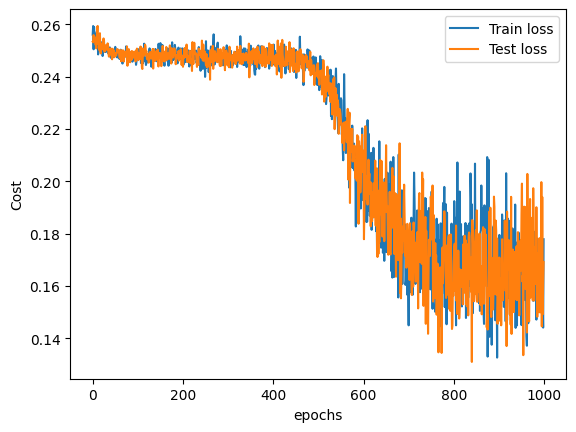

Train loss value after 1000 epochs: 0.17787010967731476
Vaildation loss value after 1000 epochs: 0.1691247522830963


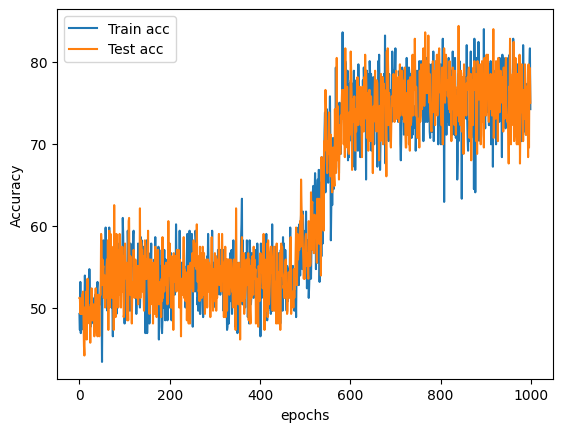

Best Test Accuracy: 84.375%


In [25]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

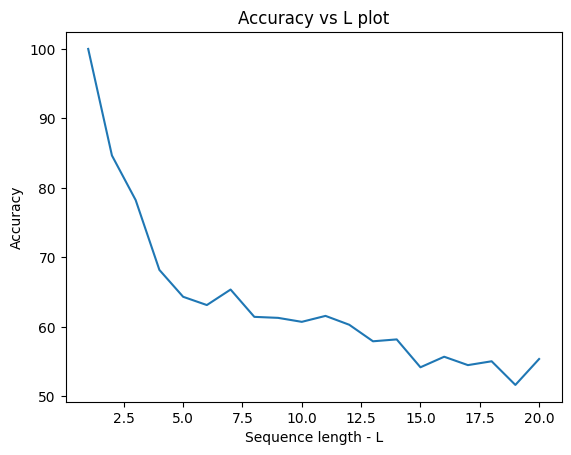

In [27]:
plot_accuracy_vs_length(model)

### Length of Input Sequence = 5

In [28]:
L = 5

In [29]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [33]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.23662230372428894. Validation Accuracy: 59.895833333333336
Epoch: 1. Train Loss: 0.2418895959854126. Validation Accuracy: 58.59375
Epoch: 2. Train Loss: 0.23741045594215393. Validation Accuracy: 55.46875
Epoch: 3. Train Loss: 0.23552116751670837. Validation Accuracy: 63.28125
Epoch: 4. Train Loss: 0.2368830442428589. Validation Accuracy: 59.375
Epoch: 5. Train Loss: 0.2371053695678711. Validation Accuracy: 59.375
Epoch: 6. Train Loss: 0.2377779185771942. Validation Accuracy: 62.760416666666664
Epoch: 7. Train Loss: 0.2394515872001648. Validation Accuracy: 62.5
Epoch: 8. Train Loss: 0.23536905646324158. Validation Accuracy: 67.70833333333333
Epoch: 9. Train Loss: 0.2332640141248703. Validation Accuracy: 65.625
Epoch: 10. Train Loss: 0.23605918884277344. Validation Accuracy: 67.1875
Epoch: 11. Train Loss: 0.2299691140651703. Validation Accuracy: 64.84375
Epoch: 12. Train Loss: 0.23995690047740936. Validation Accuracy: 64.32291666666667
Epoch: 13. Train Loss: 0.230

#### Train and test plots

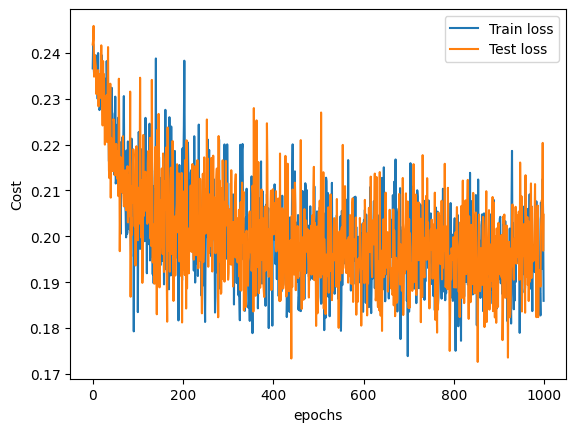

Train loss value after 1000 epochs: 0.18594537675380707
Vaildation loss value after 1000 epochs: 0.20471921563148499


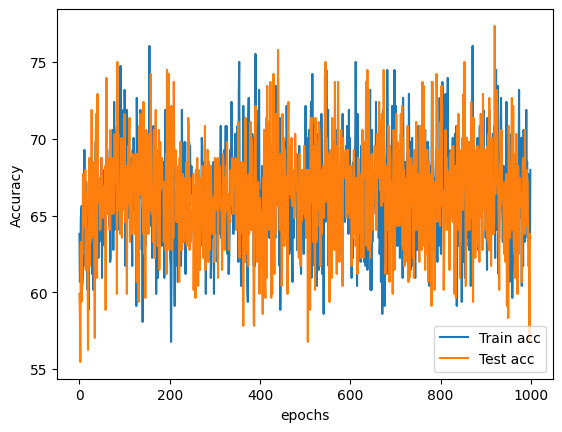

Best Test Accuracy: 77.34375%


In [34]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

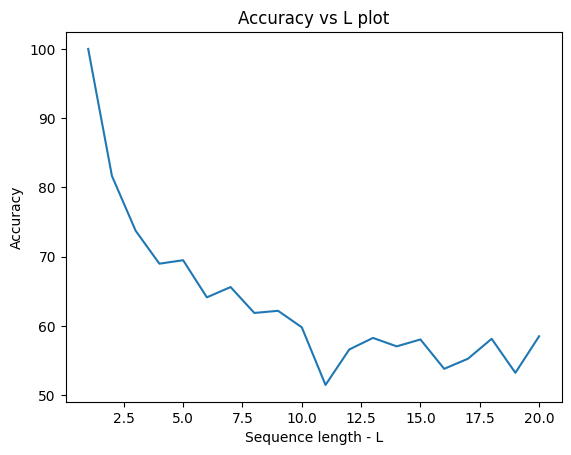

In [35]:
plot_accuracy_vs_length(model)

### Length of Input Sequence = 10

In [48]:
L = 10

In [49]:
model = BinaryAdder(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

#### Training

In [50]:
train_costs, train_acc, val_costs, val_acc = train_model(model, criterion, optimizer, K, L)

Epoch: 0. Train Loss: 0.25105199217796326. Validation Accuracy: 47.58522727272727
Epoch: 1. Train Loss: 0.2511880099773407. Validation Accuracy: 48.29545454545455
Epoch: 2. Train Loss: 0.25234901905059814. Validation Accuracy: 49.14772727272727
Epoch: 3. Train Loss: 0.25248318910598755. Validation Accuracy: 50.99431818181818
Epoch: 4. Train Loss: 0.252188116312027. Validation Accuracy: 49.85795454545455
Epoch: 5. Train Loss: 0.25078320503234863. Validation Accuracy: 50.56818181818182
Epoch: 6. Train Loss: 0.2493717521429062. Validation Accuracy: 49.28977272727273
Epoch: 7. Train Loss: 0.25042134523391724. Validation Accuracy: 50.85227272727273
Epoch: 8. Train Loss: 0.25227808952331543. Validation Accuracy: 50.85227272727273
Epoch: 9. Train Loss: 0.25061336159706116. Validation Accuracy: 51.5625
Epoch: 10. Train Loss: 0.25310730934143066. Validation Accuracy: 51.70454545454545
Epoch: 11. Train Loss: 0.2512250542640686. Validation Accuracy: 47.72727272727273
Epoch: 12. Train Loss: 0.2516

#### Train and test plots

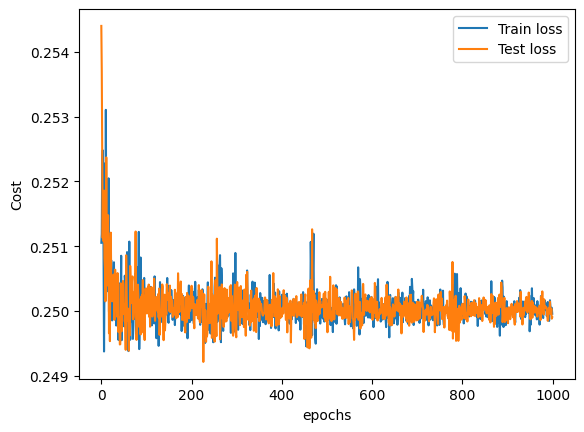

Train loss value after 1000 epochs: 0.24995453655719757
Vaildation loss value after 1000 epochs: 0.24990099668502808


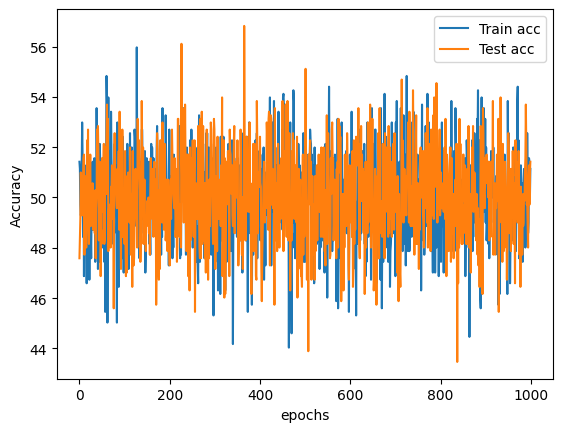

Best Test Accuracy: 56.81818181818182%


In [51]:
plot_curves(train_costs, train_acc, val_costs, val_acc)

#### Bitwise Accuracy vs Length

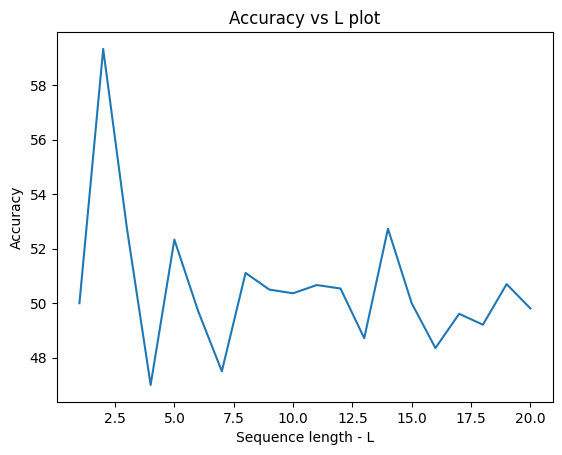

In [52]:
plot_accuracy_vs_length(model)

### Summary

Train Seq Length | Accuracy (MSE) | Accuracy (Cross Entropy) |
-------------------|------------------|---------------|
      3 |  84.375% |  86.71875% |
        5 | 77.34375% | 76.56%  |
       10 |  56.8181% | 66.4772%  |

* Loss values observed with MSE are lower than those with cross entropy. This is expected because the Cross entropy loss function is known to penalize misclassifications more strictly.
* The performance of the model with the 2 loss functions is similar when trained on small sequences but it drops drastically and almost acts like it is random guessing when it is trained on longer strings.